# Installations

In [1]:
!pip install torch_geometric
!pip install torch torchvision torchaudio
!pip -q install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:00


# Imports

In [2]:
# Tensors and neural net functions
import torch
import torch.nn.functional as F
# GNN Layers
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
# Auto-downloads citation graph datasets
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
# Math
import numpy as np
import pandas as pd
import random
# Adejancy matrix
import networkx as nx
from sklearn.cluster import KMeans #  For clustering
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score # For evaluating
from __future__ import annotations

from typing import Dict, Hashable, Iterable, Optional, Tuple
from scipy.sparse import csr_matrix
from itertools import combinations
from scipy.sparse import coo_matrix, csr_matrix
from numpy.linalg import eigh # use in SpecF
from typing import List
# Plots
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# used to align cluster IDs with most common true labels
from scipy.stats import mode

from collections import defaultdict, Counter
from collections import deque
from openpyxl import load_workbook
from openpyxl.styles import Alignment
from IPython.display import HTML, display
from pathlib import Path
import math
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import gdown
import matplotlib.colors as mcolors

#GCN Implementation flow

In [3]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels) # Aggregates 1-hop neighbors
        self.conv2 = GCNConv(hidden_channels, out_channels) # Aggregates 2-hop neighbors

    def forward(self, x, edge_index):
        # first layer
        x = self.conv1(x, edge_index)
        # non linar activation
        x = F.relu(x)
        # second layer
        x = self.conv2(x, edge_index)
        # convert embeddings into probabilities
        return F.log_softmax(x, dim=1)

# Loading Cora & setting up training

In [4]:
OUT_DIR = Path("/content/Data")
OUT_DIR.mkdir(parents=True, exist_ok=True)

FILE_ID = "1AVsRxfPzqIJTwpethlWckJ5YMRp_mwOV"
FILENAME = "original_cora_preprocessed.pt"

out_path = OUT_DIR / FILENAME

if not out_path.exists():
    url = f"https://drive.google.com/uc?id={FILE_ID}"
    gdown.download(url, str(out_path), quiet=False)
else:
    print("File already exists, skipping download.")

print("\n✅ File ready at:", out_path)


Downloading...
From: https://drive.google.com/uc?id=1AVsRxfPzqIJTwpethlWckJ5YMRp_mwOV
To: /content/Data/original_cora_preprocessed.pt
100%|██████████| 25.6M/25.6M [00:00<00:00, 73.3MB/s]


✅ File ready at: /content/Data/original_cora_preprocessed.pt


In [5]:
# 1. Load your custom file with weights_only=False
print("Loading dataset...")
data = torch.load('Data/original_cora_preprocessed.pt', weights_only=False)

# 2. Define features and classes directly from the data
num_features = data.x.shape[1]           # Get feature dimension (1433)
num_classes = len(torch.unique(data.y))  # Count unique labels (7)

# 3. Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features, 16, num_classes).to(device)
data = data.to(device)

# 4. Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

print(f"Success! Model initialized for {num_classes} classes and {num_features} features.")
print(f"Example Title: {data.titles[0]}")

Loading dataset...
Success! Model initialized for 7 classes and 1433 features.
Example Title: Stochastic Propositionalization of Non-Determinate Background Knowledge


##Train & evaluation

In [6]:
def train():
    model.train() # sets the model in training mode
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)             # log-probs [num_nodes, num_classes]
    # Uses only training nodes. Compares predicted log-probs to true labels;
    # lower loss = better classification.
    loss = F.nll_loss(out[data.train_mask],          # NLL since model returns log_softmax
                      data.y[data.train_mask])
    loss.backward()
    optimizer.step() # updates weights using gradients
    return float(loss) # return the loss

@torch.no_grad()
def test():
    model.eval()
    # Runs forward pass, takes the class with highest log-prob for each node → predicted labels.
    out = model(data.x, data.edge_index).argmax(dim=1)
    def acc(mask):
        return (out[mask] == data.y[mask]).float().mean().item()
    return acc(data.train_mask), acc(data.val_mask), acc(data.test_mask)

# Repeats training for 200 epochs
# Every 20 epochs prints current loss and train/val/test accuracies.
# This part teaches GraphSAGE model to classify Cora nodes correctly.
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        tr, va, te = test()
        print(f"Epoch {epoch:03d} | loss {loss:.4f} | accs (train/val/test): {tr:.3f}/{va:.3f}/{te:.3f}")


/tmp/ipython-input-1465345260.py:11: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  return float(loss) # return the loss


Epoch 020 | loss 1.2472 | accs (train/val/test): 0.579/0.470/0.528
Epoch 040 | loss 0.6518 | accs (train/val/test): 0.836/0.650/0.665
Epoch 060 | loss 0.3026 | accs (train/val/test): 0.957/0.724/0.717
Epoch 080 | loss 0.1218 | accs (train/val/test): 0.993/0.770/0.730
Epoch 100 | loss 0.0443 | accs (train/val/test): 1.000/0.780/0.739
Epoch 120 | loss 0.0251 | accs (train/val/test): 1.000/0.782/0.747
Epoch 140 | loss 0.0185 | accs (train/val/test): 1.000/0.782/0.749
Epoch 160 | loss 0.0153 | accs (train/val/test): 1.000/0.792/0.751
Epoch 180 | loss 0.0135 | accs (train/val/test): 1.000/0.796/0.748
Epoch 200 | loss 0.0123 | accs (train/val/test): 1.000/0.798/0.748


##Generating embeddings using GCN

In [7]:
def get_gcn_embeddings(model, data):
    """
    Returns:
      h1: 1-hop embeddings  [N, hidden_dim]
      h2: 2-hop embeddings  [N, out_dim]  (pre-softmax/log-softmax)
    """
    model.eval()
    h1 = F.relu(model.conv1(data.x, data.edge_index))
    h2 = model.conv2(h1, data.edge_index)  # <-- use pre-softmax as embeddings
    # Return the 2-hop structural embedding for each node
    return h2

##Clustering using K-means

In [8]:
h2 = get_gcn_embeddings(model, data)
Z = h2  # tensor [N, D]
X = Z.detach().cpu().numpy()

# Sets number of clusters = number of ground truth classes in Cora (7).
k = int(torch.unique(data.y).numel())

# Run K-means
km = KMeans(n_clusters=k, n_init=10, random_state=0)
pred_clusters = km.fit_predict(X)

#  evaluate clustering quality
y_true = data.y.cpu().numpy()



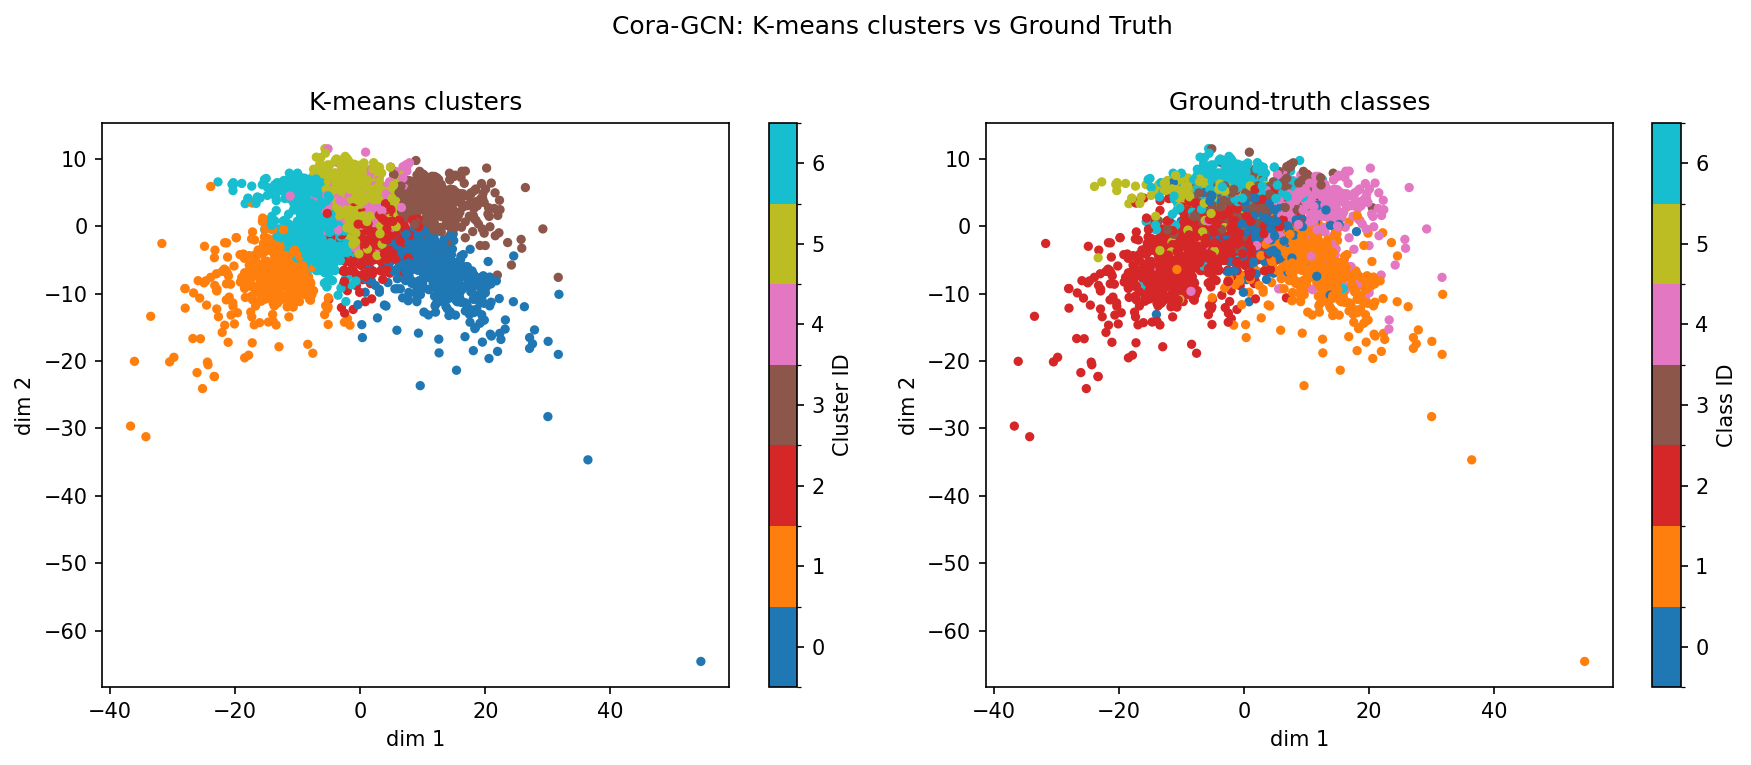

Saved plot to: /content/Results/KMeans_vs_GroundTruth.png
k (clusters) = 7 | #classes = 7


In [9]:
# --------------------------------------------------
# Reduce embeddings to 2D
# --------------------------------------------------
pca = PCA(n_components=2, random_state=0)
X2 = pca.fit_transform(X)

# --------------------------------------------------
# Discrete colormaps (so categories are clearly separated)
# --------------------------------------------------
k_clusters = int(np.unique(pred_clusters).size)
k_labels   = int(np.unique(y_true).size)

cmap_clusters = plt.get_cmap("tab20", k_clusters) if k_clusters > 10 else plt.get_cmap("tab10", k_clusters)
cmap_labels   = plt.get_cmap("tab20", k_labels)   if k_labels > 10 else plt.get_cmap("tab10", k_labels)

norm_clusters = mcolors.BoundaryNorm(np.arange(-0.5, k_clusters + 0.5, 1), cmap_clusters.N)
norm_labels   = mcolors.BoundaryNorm(np.arange(-0.5, k_labels + 0.5, 1), cmap_labels.N)

# --------------------------------------------------
# Results folder
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
out_png = RESULTS_DIR / "KMeans_vs_GroundTruth.png"

# --------------------------------------------------
# One figure with two panels
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

# LEFT: raw KMeans cluster IDs (0..k-1)
sc0 = axes[0].scatter(X2[:, 0], X2[:, 1], c=pred_clusters, s=12, cmap=cmap_clusters, norm=norm_clusters)
axes[0].set_title("K-means clusters")
axes[0].set_xlabel("dim 1")
axes[0].set_ylabel("dim 2")

# RIGHT: ground-truth labels (real class IDs)
sc1 = axes[1].scatter(X2[:, 0], X2[:, 1], c=y_true, s=12, cmap=cmap_labels, norm=norm_labels)
axes[1].set_title("Ground-truth classes")
axes[1].set_xlabel("dim 1")
axes[1].set_ylabel("dim 2")

# Colorbars (make IDs explicit)
cbar0 = fig.colorbar(sc0, ax=axes[0], ticks=range(k_clusters))
cbar0.set_label("Cluster ID")

cbar1 = fig.colorbar(sc1, ax=axes[1], ticks=range(k_labels))
cbar1.set_label("Class ID")

fig.suptitle("Cora-GCN: K-means clusters vs Ground Truth", y=1.01)
fig.tight_layout()

fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")
print("k (clusters) =", k_clusters, "| #classes =", k_labels)


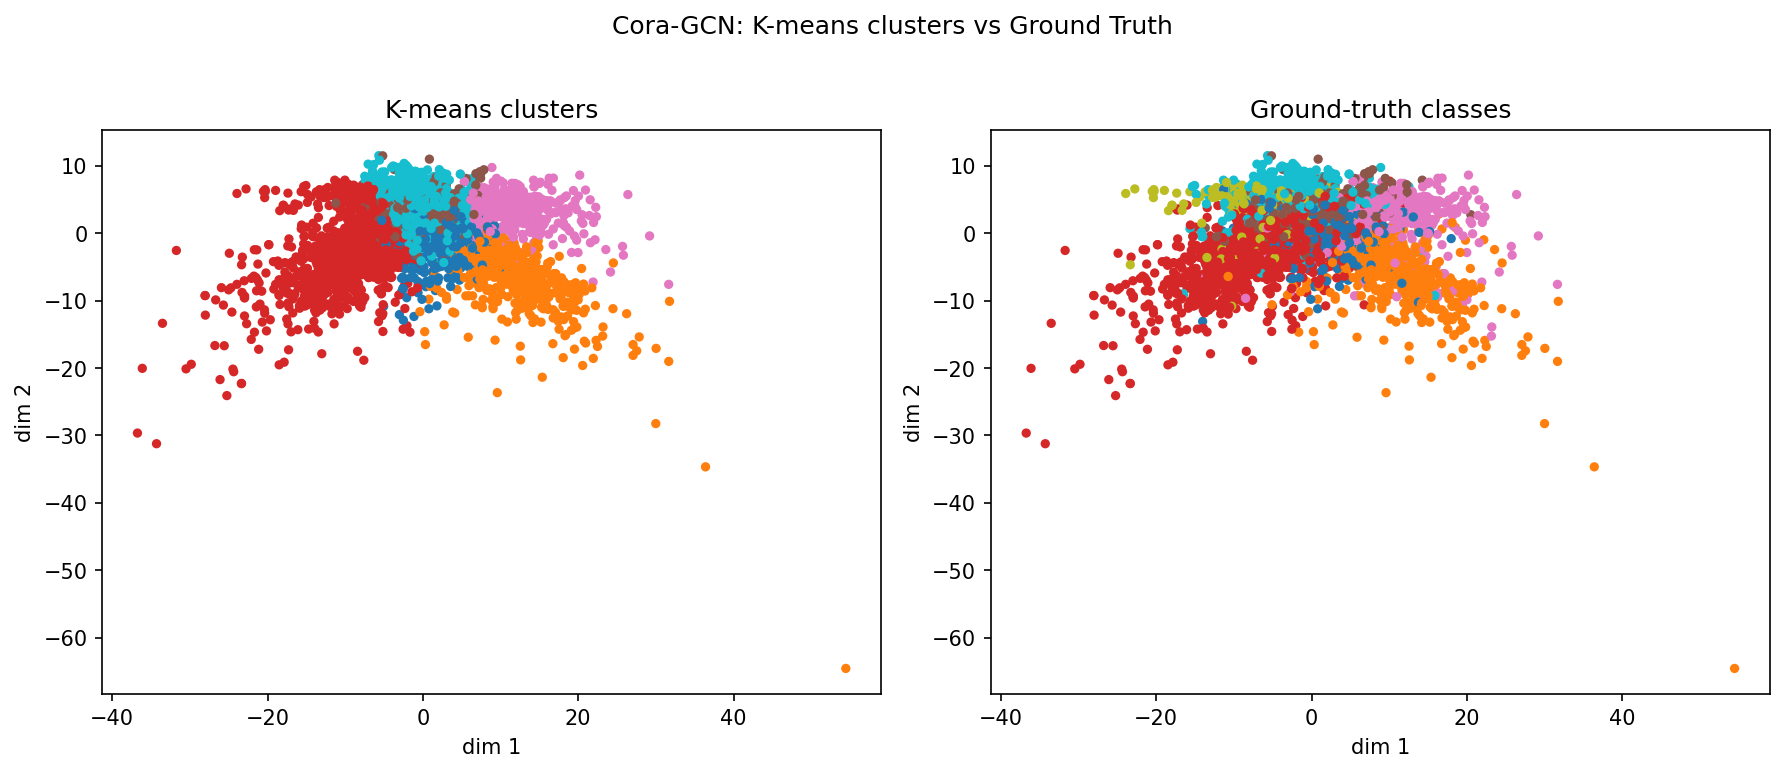

Saved plot to: /content/Results/KMeans_vs_GroundTruth_map.png


In [10]:
# --------------------------------------------------
# Align cluster IDs to dominant true labels
# --------------------------------------------------
def align_clusters_to_labels(clusters, true_labels):
    clusters_aligned = np.zeros_like(clusters)
    for cluster_id in np.unique(clusters):
        mask = clusters == cluster_id
        most_common_label = mode(true_labels[mask], keepdims=False).mode
        clusters_aligned[mask] = most_common_label
    return clusters_aligned

clusters_aligned = align_clusters_to_labels(pred_clusters, y_true)

# --------------------------------------------------
# Reduce embeddings to 2D
# --------------------------------------------------
pca = PCA(n_components=2, random_state=0)
X2 = pca.fit_transform(X)

# --------------------------------------------------
# Results folder
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "KMeans_vs_GroundTruth_map.png"

# --------------------------------------------------
# One figure with two panels
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

axes[0].scatter(X2[:, 0], X2[:, 1], c=clusters_aligned, s=12, cmap="tab10")
axes[0].set_title("K-means clusters")
axes[0].set_xlabel("dim 1")
axes[0].set_ylabel("dim 2")

axes[1].scatter(X2[:, 0], X2[:, 1], c=y_true, s=12, cmap="tab10")
axes[1].set_title("Ground-truth classes")
axes[1].set_xlabel("dim 1")
axes[1].set_ylabel("dim 2")

fig.suptitle("Cora-GCN: K-means clusters vs Ground Truth", y=1.02)
fig.tight_layout()

# Save under Results
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")

## Build expanded Adjacency Matrix
The purpose is:
Constructs the expanded adjacency matrix W used in SpecF, encoding both: actual edges, and same-community non-edges

In [11]:


def build_expanded_adjacency(
    G: nx.Graph,
    communities: Dict[Hashable, int],
    *,
    w_edge_same: int = 5,
    w_edge_diff: int = 3,
    w_nonedge_same: int = 1,
    return_node_order: bool = False,
) -> Tuple[csr_matrix, list] | csr_matrix:
    """
    Build the expanded adjacency matrix W (Eq. (10) in the paper).

    Parameters
    ----------
    G : nx.Graph
        Undirected graph.
    communities : dict
        Mapping node -> community id (your K-means clusters).
    w_edge_same : int
        Weight if i-j are neighbors and in the same community (default 5).
    w_edge_diff : int
        Weight if i-j are neighbors in different communities (default 3).
    w_nonedge_same : int
        Weight if i-j are NOT neighbors and in the same community (default 1).
    return_node_order : bool
        If True, also returns the node order used for indexing rows/cols.

    Returns
    -------
    W : scipy.sparse.csr_matrix, shape (N, N)
        Expanded adjacency matrix.
    node_order : list (optional)
        The node order corresponding to rows/cols of W (only if return_node_order=True).
    """
    # fix node order (rows/cols)
    nodes = list(G.nodes())
    N = len(nodes)
    idx = {u: i for i, u in enumerate(nodes)}

    # neighbor sets
    nbrs = {u: set(G.neighbors(u)) for u in nodes}

    rows, cols, data = [], [], []

    # 1) Add all existing edges with weights 5 or 3
    for u, v in G.edges():
        i, j = idx[u], idx[v]
        same = (communities.get(u) == communities.get(v))
        w = w_edge_same if same else w_edge_diff
        rows.extend([i, j])
        cols.extend([j, i])
        data.extend([w, w])

    # 2) Add same-community non-edges (weight 1)
    # Group nodes by community
    comm2nodes: Dict[int, list] = {}
    for u, c in communities.items():
        comm2nodes.setdefault(c, []).append(u)

    for c, c_nodes in comm2nodes.items():
        # iterate unordered pairs inside the community
        for u, v in combinations(c_nodes, 2):
            # skip if (u,v) already an edge
            if v in nbrs[u]:
                continue
            i, j = idx[u], idx[v]
            rows.extend([i, j])
            cols.extend([j, i])
            data.extend([w_nonedge_same, w_nonedge_same])

    # Build sparse; zero diagonal by default
    W = coo_matrix((data, (rows, cols)), shape=(N, N)).tocsr()

    return (W, nodes) if return_node_order else W


In [12]:

def calculate_community_seeds(G, communities):
    """
    Implements Equation 11: Calculates the seed signal s_k^c for each community.
    """
    # 1. Build the Community Graph (Gc)
    Gc = nx.Graph()
    unique_comms = sorted(list(set(communities.values())))
    Gc.add_nodes_from(unique_comms)

    # Count edges between communities
    for u, v in G.edges():
        c_u = communities[u]
        c_v = communities[v]
        if c_u != c_v:
            if Gc.has_edge(c_u, c_v):
                Gc[c_u][c_v]['weight'] += 1
            else:
                Gc.add_edge(c_u, c_v, weight=1)

    # 2. Calculate Seeds (Equation 11)
    community_signals = {}
    # Sort communities by the sum of their inter-community edge weights
    sorted_comms = sorted(unique_comms, key=lambda c: sum(d['weight'] for _, _, d in Gc.edges(c, data=True)))

    for i, c in enumerate(sorted_comms):
        # sum of weights of adjacent nodes in Gc
        w_sum = sum(d['weight'] for _, _, d in Gc.edges(c, data=True))
        # Equation 11: s_i^c = sum(w_ij^c) * (i + 1)
        community_signals[c] = float(w_sum * (i + 1))

    return community_signals

## Generating Normal Signals

Its job:

Seed a signal inside each community:

- For each community c, find nodes in that community.

- Choose a seed node with maximum degree (or random among them).

- Set its signal s_i^c to the corresponding community-level value community_signal[c].

- Everything else initially 0.

Propagate that signal outward:

- Uses a kind of queue-based propagation:

  - Maintains a set of marked/unmarked nodes.

  - Repeatedly selects a node, pushes its signal to neighbors, and averages.

- The conceptual effect: values diffuse across the graph so that nodes connected within the same community tend to have similar values.

Final smoothing with weights:

- If W_expanded and node_order are provided (fast path):

  - Build a vector sx_vec of signals in the order of node_order.

  - Compute row_sums = W_expanded.sum(axis=1) (degree in expanded graph).

  - Compute numer = W_expanded.dot(sx_vec) (weighted sum of neighbors’ signals).

  - Set s_vec = numer / row_sums where degree > 0.

  - Convert back to a dict {node: s_i}.

- This is a weighted average using expanded adjacency, so the signal is smooth with respect to both edges and community structure.

In [13]:
# BUILD NETWORKX GRAPH G FROM PyG edge_index
edge_index = data.edge_index.cpu().numpy()
G = nx.Graph()
G.add_edges_from(zip(edge_index[0], edge_index[1]))
G.add_nodes_from(range(data.num_nodes))   # ensure isolated nodes included

def normal_signal_generator(
    G: nx.Graph,
    communities: Dict[Hashable, int],               # node -> community id
    community_signal: Dict[int, float],             # community id -> seed s_k^c
    *,
    # legacy options
    use_expanded_weights: bool = False,             # if no W_expanded is given, use 5/3 scheme
    weight_attr: str = "weight",                    # edge attr for legacy averaging
    rng: Optional[random.Random] = None,
    # NEW fast path
    W_expanded: "csr_matrix" = None,                # SciPy CSR matrix (optional)
    node_order: Optional[list] = None               # nodes ordered as W_expanded rows/cols
) -> Dict[Hashable, float]:
    """
    Algorithm 4: Normal Signal Generator (paper).
    - Seeds each community at its highest-degree node with s_k^c.
    - Propagates signals along edges with community-aware transfer t.
    - Final signal is a weighted average of propagated signals.

    Fast path:
      If W_expanded (CSR) and node_order are provided, the final averaging uses:
         s = D^{-1} W_expanded @ s_x
      where D[i] = sum_j W_expanded[i, j].
    Otherwise, falls back to the legacy (loop-based) averaging.

    Returns
    -------
    s : dict {node: s_i}  Final node signals.
    """
    if rng is None:
        rng = random.Random()

    # 1. Initialization
    # S_x will hold the intermediate propagated values
    S_x: Dict[Hashable, float] = {n: 0.0 for n in G.nodes()}
    marked = {n: True for n in G.nodes()}
    degrees = dict(G.degree())

    # Queue for BFS-like propagation
    F = deque()

    # 2. Seed Selection (Heads of Communities)
    # Identify unique communities present in the graph
    present_communities = set(communities.values())

    # Pre-group nodes by community for efficiency
    nodes_by_comm = {c: [] for c in present_communities}
    for n, c in communities.items():
        if n in G:  # Ensure node is in graph
            nodes_by_comm[c].append(n)

    # Assign seed values to the highest degree node in each community
    for c in present_communities:
        nodes = nodes_by_comm[c]
        if not nodes:
            continue

        # Sort by degree (descending) then ID to break ties deterministically
        # Note: we use str(n) for ID sorting to handle mixed types if necessary
        head = max(nodes, key=lambda n: (degrees[n], str(n)))

        # Assign the seed signal for this community
        if c in community_signal:
            S_x[head] = community_signal[c]
            marked[head] = False
            F.append(head)

    # 3. Propagation Process (The core of Algorithm 4)
    while F:
        v_i = F.popleft()
        val_i = S_x[v_i]

        # Get neighbors (sorted for determinism if needed, but omitted for speed)
        neighbors = list(G.neighbors(v_i))

        for v_j in neighbors:
            # Calculate transfer rate 't'
            # If same community: t depends on degrees
            if communities[v_i] == communities[v_j]:
                d_i = degrees[v_i]
                d_j = degrees[v_j]
                denom = d_i + d_j
                mt = (d_i / denom) if denom > 0 else 0
                t = max(0.25, mt)
            else:
                # Different community: fixed low transfer rate
                t = 0.1

            # Update neighbor value: s_j <- s_j + (s_i * t)
            S_x[v_j] += val_i * t

            # Decay source value: s_i <- s_i * 0.95
            S_x[v_i] *= 0.95
            # Update local var to reflect decay for next neighbor (optional interpretation,
            # but usually decay happens once per propagation step.
            # Sticking to the paper's "After the propagation process... reduced by 5%" implies
            # it might happen after interacting with all neighbors, but iterative implementations
            # often decay per interaction. Here we decay the source *in the dict*.)

            # Add neighbor to queue if it hasn't been a source yet
            if marked[v_j]:
                marked[v_j] = False
                F.append(v_j)

        # Update the decayed value in the main dict for v_i
        S_x[v_i] = val_i * 0.95

    # 4. Final Normalization
    # We apply the weighted average smoothing.

    # PATH A: Fast path with Precomputed W_expanded
    if W_expanded is not None:
        if node_order is None:
            raise ValueError("node_order must be provided if W_expanded is used.")

        # Create a vector aligned with node_order
        n_nodes = len(node_order)
        s_vector = np.zeros(n_nodes)

        # Map S_x dict to vector
        # Create a fast lookup for node indices
        node_to_idx = {n: i for i, n in enumerate(node_order)}

        for n, val in S_x.items():
            if n in node_to_idx:
                s_vector[node_to_idx[n]] = val

        # Perform matrix multiplication: S_smooth = D^-1 * W * S
        # Compute sum of weights (degrees) for normalization
        # W_expanded is CSR, sum(axis=1) returns a matrix (n,1), flatten to array
        weighted_sums = W_expanded.dot(s_vector)
        degree_sums = np.array(W_expanded.sum(axis=1)).flatten()

        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            s_smooth_vec = weighted_sums / degree_sums
            s_smooth_vec = np.nan_to_num(s_smooth_vec)

        # Map back to dict
        return {n: float(s_smooth_vec[i]) for i, n in enumerate(node_order)}

    # PATH B: Legacy Manual Calculation
    else:
        S_final = {}
        for i in G.nodes():
            neighbors = list(G.neighbors(i))

            # If isolated, keep original value
            if not neighbors:
                S_final[i] = S_x[i]
                continue

            numerator = 0.0
            denominator = 0.0

            # Define weights based on strategy
            if use_expanded_weights:
                # "Expanded" strategy: 5 for same comm, 3 for diff comm
                # We include self-loop with weight 5 (high affinity to self/comm)

                # Self
                w_self = 5.0
                numerator += w_self * S_x[i]
                denominator += w_self

                c_i = communities[i]

                for j in neighbors:
                    if c_i == communities[j]:
                        w = 5.0
                    else:
                        w = 3.0
                    numerator += w * S_x[j]
                    denominator += w
            else:
                # Standard strategy: use edge weight attribute or 1.0
                # Self (standard usually doesn't emphasize self as heavily, using 1.0 or 0)
                # Here we strictly average neighbors + self? Or just neighbors?
                # Standard smoothing usually involves self. Let's assume weight 1 for self.
                numerator += S_x[i]
                denominator += 1.0

                for j in neighbors:
                    w = G[i][j].get(weight_attr, 1.0)
                    numerator += w * S_x[j]
                    denominator += w

            S_final[i] = numerator / denominator if denominator > 0 else 0.0

        return S_final

# 1. Map communities
clusters_dict = {i: int(c) for i, c in enumerate(pred_clusters)}

# 2. CALCULATE SEEDS (The missing step)
# This uses the inter-community edge counts to set the base intensity
Sc = calculate_community_seeds(G, clusters_dict)

# 3. Build W_expanded
W_expanded, node_order = build_expanded_adjacency(G, clusters_dict, return_node_order=True)

# 4. Propagation (Algorithm 4)
# Now Sc contains the paper-derived s_k^c values
S_normal = normal_signal_generator(
    G,
    communities=clusters_dict,
    community_signal=Sc,
    W_expanded=W_expanded,
    node_order=node_order
)

B = S_normal

# Visualization of the signal 𝐵 on the nodes embeddings

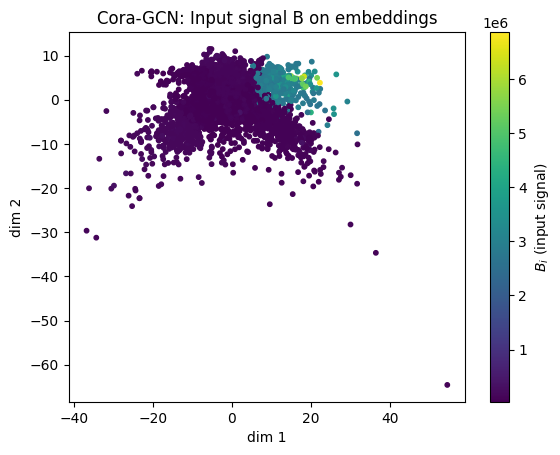

In [14]:
# convert dict -> array, assuming node ids are 0..N-1
vals_B = np.array([B[i] for i in range(len(B))])

plt.figure()
plt.scatter(X2[:,0], X2[:,1], c=vals_B, s=10, cmap="viridis")
plt.colorbar(label=r"$B_i$ (input signal)")
plt.title("Cora-GCN: Input signal B on embeddings")
plt.xlabel("dim 1"); plt.ylabel("dim 2")
plt.show()


#**SpecF**

In [15]:
def specf_anomaly_detection(
    W_expanded: csr_matrix,
    B: Dict[Hashable, float],          # anomalous signal: node -> b_i
    communities: Dict[Hashable, int],  # node -> community id (from K-means)
    node_order: list,                  # order used when building W_expanded
    k: int | None = None               # how many low-frequency eigencomponents to keep; if None use number of communities
):
    """
    SpecF implementation:
    - Build Laplacian L = D - W
    - Graph Fourier transform of B
    - Ideal low-pass filtering using cutoff λ_k
    - Inverse transform to get B'
    - Y = |B - B'| and per-community thresholding to get anomalies
    """

    # 1. Build signal vector in the same order as W_expanded
    N = W_expanded.shape[0]
    assert len(node_order) == N, "node_order must match W_expanded shape"
    b_vec = np.array([B[n] for n in node_order], dtype=float)

    # 2. Build Graph Laplacian L = D - W_expanded
    deg = np.array(W_expanded.sum(axis=1)).ravel() # deg[i] = sum of weights from node i to its neighbors in W_expanded
    # np.diag(deg) = degree matrix D
    L = np.diag(deg) - W_expanded.toarray()

    # 3. Eigen-decomposition: L = U Λ U^T
    # eigvals = eigenvalues λ0​ ≤ λ1​ ≤ ⋯ ≤ λN−1
    # ​U = matrix whose columns u0 ​, u1 ​, … , uN−1 are orthonormal eigenvectors.
    # Each eigenpair (λ_l​,u_l​) is a frequency mode on the graph.
    # Small λ → smooth mode: neighboring nodes have similar values.
    # Large λ → high-frequency mode: values change rapidly between neighbors.

    eigvals, U = eigh(L)  # eigvals sorted ascending for symmetric matrices

    # 4. Choose cutoff λ_k based on communities
    if k is None:
        # use the number of discovered communities
        k = len(set(communities.values()))

    # defensive clamp (in case k is weird)
    k = max(1, min(k, len(eigvals) - 1))

    # All eigenvalues smaller than this are considered low frequency.
    # All greater or equal are treated as high frequency and removed.
    # so we keep the first k smoothest eigenmodes, discard the rest.
    lambda_cut = eigvals[k]  # λ_cut = λ_k  (0-based index) :contentReference[oaicite:1]{index=1}

    # 5. Graph Fourier transform of B
    # B̂ = U^T B
    # b_hat[l] is the coefficient of signal b_vec on eigenvector u_l.
    # It tells us how much of frequency λ_l is present in B.
    # Low l → smooth component
    # High l → noisy / anomalous variation
    b_hat = U.T @ b_vec

    # 6. Ideal low-pass filter
    # h(λ_l) = 1 if λ_l < λ_cut, 0 otherwise
    # Keep only smooth components (low λ).
    # Throw away high-frequency components (sharp local variations).
    alpha = (eigvals < lambda_cut).astype(float)
    # filtered spectrum B̂' = h(λ) ⊙ B̂
    b_hat_f = alpha * b_hat

    # inverse graph Fourier transform: B' = U B̂'
    # b_prime[i] is the value of the smoothed signal at node i
    b_prime = U @ b_hat_f

    # 7. Anomaly scores Y = |B - B'|
    # If a node’s value was already consistent with neighbors (smooth), then:  b_i ≈ b'_i → y_i small.
    # If a node was weird/abrupt compared to neighbors (anomaly): b_i differs a lot from b'_i → y_i large
    y_vec = np.abs(b_vec - b_prime)
    # Y_scores[n] is raw anomaly score for node n.
    Y_scores = {n: y_vec[i] for i, n in enumerate(node_order)}  # node -> y_i

    # 8. Per-community threshold & anomaly set PAN
    # compare nodes only within their own community
    anomalies = []
    # group nodes by community
    comm_to_nodes: Dict[int, list] = {}
    for n in node_order:
        c = int(communities[n])
        comm_to_nodes.setdefault(c, []).append(n)

    for c, nodes_c in comm_to_nodes.items():
      # vals = all deviation scores y_i of nodes in community c
        vals = np.array([Y_scores[n] for n in nodes_c], dtype=float)
        if len(vals) == 0:
            continue

        mu = vals.mean()
        sigma = vals.std()
        max_val = vals.max()
        # Anything more than 2 standard deviations above the mean is suspicious.
        # TD = (mean + 2 * std) / max
        # Comparing directly on original scale is equivalent to threshold = mean + 2*std.
        threshold = mu + 2.0 * sigma


        # mark anomalies in each community
        for n, y in zip(nodes_c, vals):
            if y > threshold:        # Algorithm 3: yi greater than TD ⇒ anomalous :contentReference[oaicite:5]{index=5}
                anomalies.append(n)

    # the final anomalies list contains all nodes that:
    # Deviate a lot from their smoothed value (large |B - B′|),
    # and are unusually large compared to other nodes in their own community.
    # Y_scores: node → y_i, the continuous anomaly score.
    return Y_scores, anomalies

In [16]:
# Calling SpecF Algorithm
k_communities = len(set(clusters_dict.values()))
print("Number of communities (k):", k_communities)

Y_scores, specf_anomalies = specf_anomaly_detection(
    W_expanded=W_expanded,
    B=B,
    communities=clusters_dict,
    node_order=node_order,
    k=k_communities
)

print(f"SpecF flagged {len(specf_anomalies)} anomalous nodes.")
print("First 10:", specf_anomalies[:10])



Number of communities (k): 7
SpecF flagged 136 anomalous nodes.
First 10: [np.int64(2994), np.int64(4199), np.int64(4195), np.int64(2559), np.int64(2768), np.int64(2773), np.int64(2081), np.int64(3278), np.int64(3393), np.int64(3420)]


# Results

# Nodes Colored by SpecF Score 𝑌𝑖 with anomalous in red circle

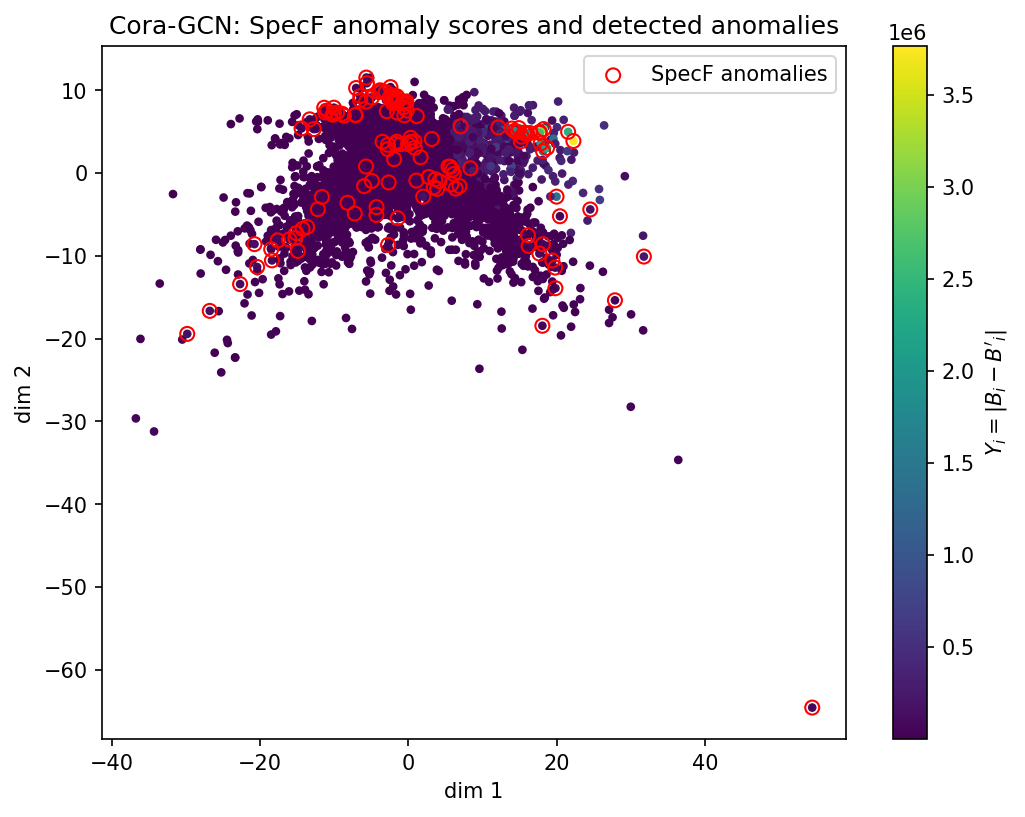

Saved plot to: /content/Results/SpecF_scores_with_anomalies.png


In [17]:
# SpecF score vector in node-id order 0..N-1
N = len(node_order)  # should equal data.num_nodes
vals_Y = np.array([Y_scores[i] for i in range(N)], dtype=float)

# anomaly mask for highlighting circles
mask = np.zeros(N, dtype=bool)
mask[specf_anomalies] = True

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "SpecF_scores_with_anomalies.png"


fig = plt.figure(figsize=(8, 6), dpi=150)
sc = plt.scatter(X2[:, 0], X2[:, 1], c=vals_Y, s=10, cmap="viridis")
plt.colorbar(sc, label=r"$Y_i = |B_i - B'_i|$")

plt.scatter(
    X2[mask, 0], X2[mask, 1],
    s=45, edgecolors="red", facecolors="none", linewidths=1.0,
    label="SpecF anomalies"
)

plt.legend(loc="best")
plt.title("Cora-GCN: SpecF anomaly scores and detected anomalies")
plt.xlabel("dim 1")
plt.ylabel("dim 2")

# Save under Results
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")

# Nodes Colored by B𝑖 Score with anomalous in red circle

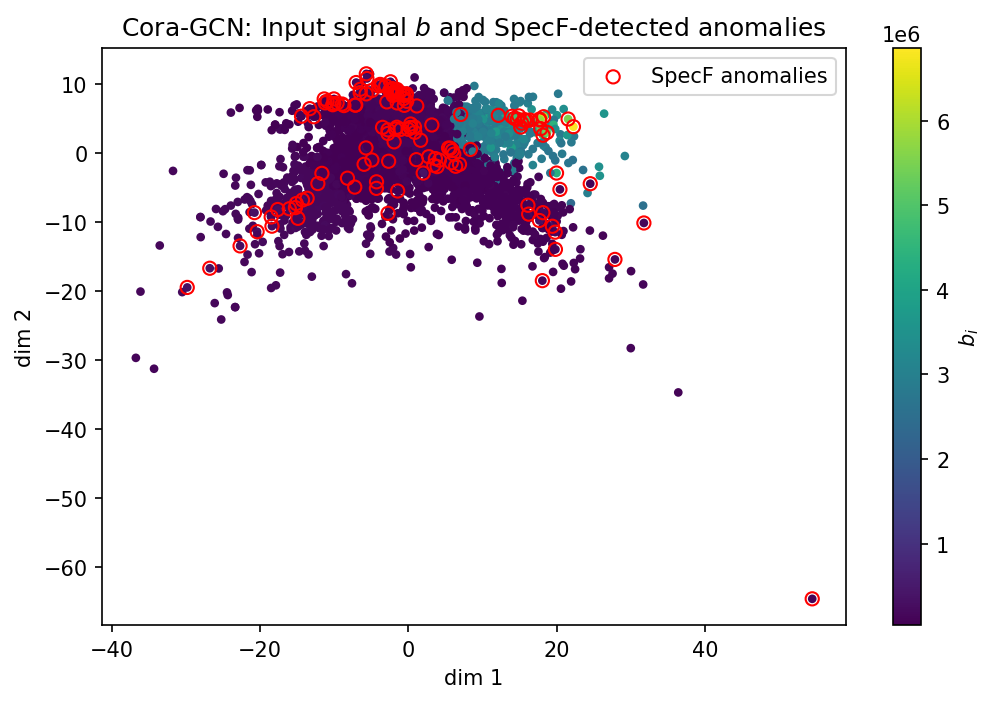

Saved plot to: /content/Results/InputSignal_b_with_anomalies.png


In [18]:
# --------------------------------------------------
# Input signal b in node-id order 0..N-1
# --------------------------------------------------
N = len(node_order)  # should equal data.num_nodes
vals_b = np.array([B[i] for i in range(N)], dtype=float)

# anomaly mask for highlighting circles
mask = np.zeros(N, dtype=bool)
mask[specf_anomalies] = True

# --------------------------------------------------
# Results folder
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "InputSignal_b_with_anomalies.png"

# --------------------------------------------------
# Plot
# --------------------------------------------------
fig = plt.figure(figsize=(8, 5), dpi=150)

sc = plt.scatter(
    X2[:, 0], X2[:, 1],
    c=vals_b, s=10, cmap="viridis"
)
plt.colorbar(sc, label=r"$b_i$")

# highlight SpecF anomalies
plt.scatter(
    X2[mask, 0], X2[mask, 1],
    s=40, edgecolors="red", facecolors="none",
    linewidths=1.0, label="SpecF anomalies"
)

plt.legend(loc="best")
plt.title("Cora-GCN: Input signal $b$ and SpecF-detected anomalies")
plt.xlabel("dim 1")
plt.ylabel("dim 2")

# Save under Results
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")


# Visualize Anomalous nodes Detected by SpecF in PCA Space

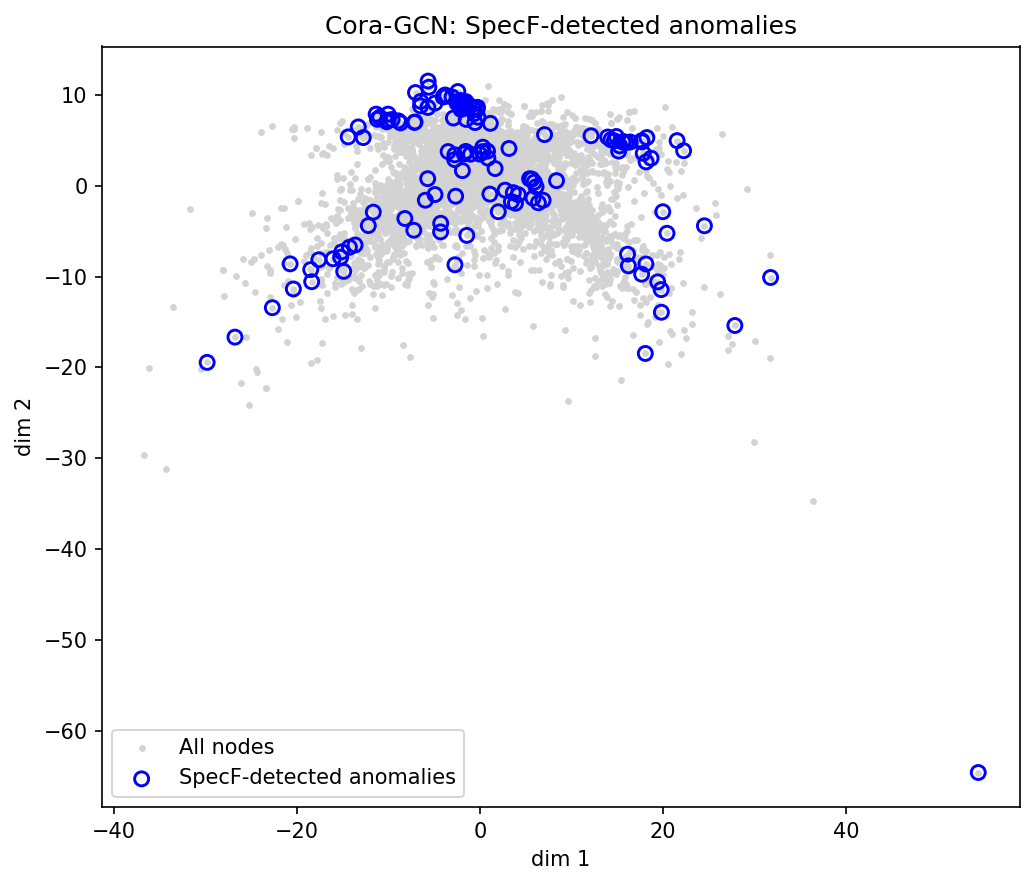

Saved plot to: /content/Results/SpecF_detected_anomalies.png


In [19]:
N = len(node_order)
specf_set = set(specf_anomalies)


# SpecF flagged nodes only (no TP/FN/FP without ground truth)
mask_anom = np.zeros(N, dtype=bool)
mask_anom[list(specf_set)] = True   # SpecF-detected anomalies

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "SpecF_detected_anomalies.png"

fig = plt.figure(figsize=(7, 6), dpi=150)

# background: all nodes
plt.scatter(X2[:, 0], X2[:, 1], s=5, color="lightgray", label="All nodes")

# SpecF anomalies
plt.scatter(
    X2[mask_anom, 0], X2[mask_anom, 1],
    s=45, edgecolors="blue", facecolors="none",
    linewidths=1.4, label="SpecF-detected anomalies"
)

plt.legend()
plt.title("Cora-GCN: SpecF-detected anomalies")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.tight_layout()

# Save under Results
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")


# Community Structure in PCA Space with SpecF Anomalies

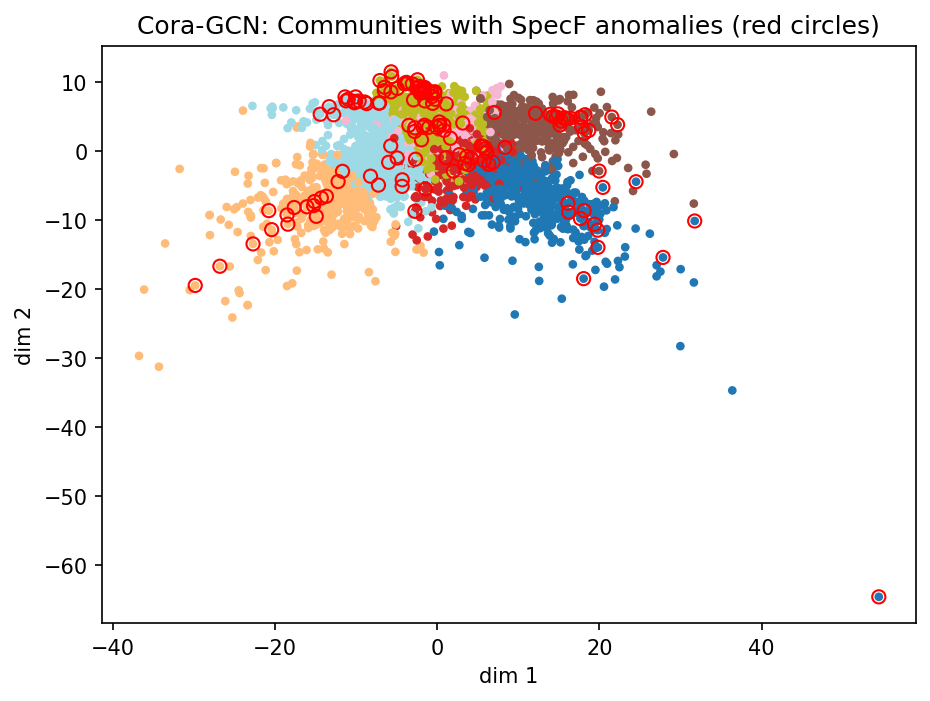

Saved plot to: /content/Results/Communities_with_SpecF_anomalies.png


In [20]:
comm_vec = np.array([clusters_dict[i] for i in range(len(node_order))], dtype=int)

mask = np.zeros(len(node_order), dtype=bool)
mask[specf_anomalies] = True

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "Communities_with_SpecF_anomalies.png"

fig = plt.figure(figsize=(7, 5), dpi=150)

plt.scatter(X2[:, 0], X2[:, 1], c=comm_vec, s=10, cmap="tab20")
plt.scatter(
    X2[mask, 0], X2[mask, 1],
    s=40, edgecolors="red", facecolors="none",
    linewidths=1.0
)

plt.title("Cora-GCN: Communities with SpecF anomalies (red circles)")
plt.xlabel("dim 1")
plt.ylabel("dim 2")

# Save under Results
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")


# Anomalous nodes and their title, subject, community and score

In [21]:
# --------------------------------------------------
# 1. Cora subject mapping
# --------------------------------------------------
cora_subjects = {
    0: "Case_Based",
    1: "Genetic_Algorithms",
    2: "Neural_Networks",
    3: "Probabilistic_Methods",
    4: "Reinforcement_Learning",
    5: "Rule_Learning",
    6: "Theory"
}

# --------------------------------------------------
# 2. Dataset info
# --------------------------------------------------
labels = data.y.cpu().numpy()
N = data.num_nodes

# --------------------------------------------------
# 3. Full table (now with Titles!)
# --------------------------------------------------
df_results = pd.DataFrame({
    "node_id": np.arange(N),
    "title": data.titles,  # <--- ADDED THIS LINE
    "subject_id": labels,
    "subject_name": [cora_subjects[int(l)] for l in labels],
    "community_id": [clusters_dict[i] for i in range(N)],
    "SpecF_score": [Y_scores[i] for i in range(N)]
})

# --------------------------------------------------
# 4. Keep ONLY anomalies and drop index
# --------------------------------------------------
df_anomalies = (
    df_results
    .iloc[specf_anomalies]
    .sort_values("SpecF_score", ascending=False)
    .reset_index(drop=True)
)

# --------------------------------------------------
# 5. Display
# --------------------------------------------------
# Expanding the width so you can read the full titles
pd.set_option('display.max_colwidth', None)
display(df_anomalies)


# --------------------------------------------------
# 6. Sort by title and EXPORT to Excel (Results folder)
# --------------------------------------------------

# Create Results folder (if it does not exist)
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

df_anomalies_sorted = df_anomalies.sort_values(
    by="title",
    ascending=True
)

# Full output path
output_path = RESULTS_DIR / "Cora_SpecF_anomalies_GCN.xlsx"

df_anomalies_sorted.to_excel(
    output_path,
    index=False
)

print(f"Results saved to: {output_path.resolve()}")


node_id  \
0       4290   
1       4019   
2       1801   
3       2711   
4        625   
..       ...   
131     2731   
132     1748   
133     2538   
134     3292   
135     1820   

                                                                                                      title  \
0    Between MDPs and Semi-MDPs: Learning, Planning, and Representing Knowledge at Multiple Temporal Scales   
1                                                        Multi-time Models for Temporally Abstract Planning   
2                                                                           Learning Hierarchical Behaviors   
3                                                   Intra-Option Learning about Temporally Abstract Actions   
4                                     A Unifying Framework for Temporal Abstraction in Stochastic Processes   
..                                                                                                      ...   
131            An Empirical Comparison of Voting Classification Algorithms: Bagging, Boosting, and Variants   
132                                                                                   Integrative Windowing   
133                                         A Tight Integration of Pruning and Learning (Extended Abstract)   
134                                                                 Top-Down Pruning in Relational Learning   
135                                                                      Separate-and-Conquer Rule Learning   

     subject_id            subject_name  community_id   SpecF_score  
0             4  Reinforcement_Learning             3  3.763465e+06  
1             4  Reinforcement_Learning             3  3.211323e+06  
2             4  Reinforcement_Learning             3  2.816586e+06  
3             4  Reinforcement_Learning             3  2.799076e+06  
4             4  Reinforcement_Learning             3  2.600314e+06  
..          ...                     ...           ...           ...  
131           6                  Theory             6  2.008598e+04  
132           6                  Theory             6  1.974097e+04  
133           5           Rule_Learning             6  1.966542e+04  
134           5           Rule_Learning             6  1.901746e+04  
135           5           Rule_Learning             6  1.835680e+04  

[136 rows x 6 columns]

Results saved to: /content/Results/Cora_SpecF_anomalies_GCN.xlsx


# Count NORMAL vs ANOMALOUS per subject

In [22]:
stats = defaultdict(lambda: {
    "total": 0,
    "normal": 0,
    "anomalous": 0
})

for i in range(data.num_nodes):
    lab = int(labels[i])
    stats[lab]["total"] += 1
    if i in specf_set:
        stats[lab]["anomalous"] += 1
    else:
        stats[lab]["normal"] += 1



print("\nClass-wise normal vs anomalous nodes (SpecF):\n")
print(f"{'Subject':25s} | {'Total':>5s} | {'Normal':>6s} | {'Anom':>5s} | {'Anom %':>7s}")
print("-"*65)

for lab in sorted(stats.keys()):
    s = stats[lab]
    total = s["total"]
    anom = s["anomalous"]
    normal = s["normal"]
    pct = 100.0 * anom / total if total > 0 else 0.0

    print(f"{cora_subjects[lab]:25s} | "
          f"{total:5d} | {normal:6d} | {anom:5d} | {pct:6.2f}%")



Class-wise normal vs anomalous nodes (SpecF):

Subject                   | Total | Normal |  Anom |  Anom %
-----------------------------------------------------------------
Case_Based                |   491 |    490 |     1 |   0.20%
Genetic_Algorithms        |   625 |    616 |     9 |   1.44%
Neural_Networks           |  1390 |   1365 |    25 |   1.80%
Probabilistic_Methods     |   656 |    640 |    16 |   2.44%
Reinforcement_Learning    |   354 |    315 |    39 |  11.02%
Rule_Learning             |   282 |    273 |     9 |   3.19%
Theory                    |   532 |    495 |    37 |   6.95%


**visualize**

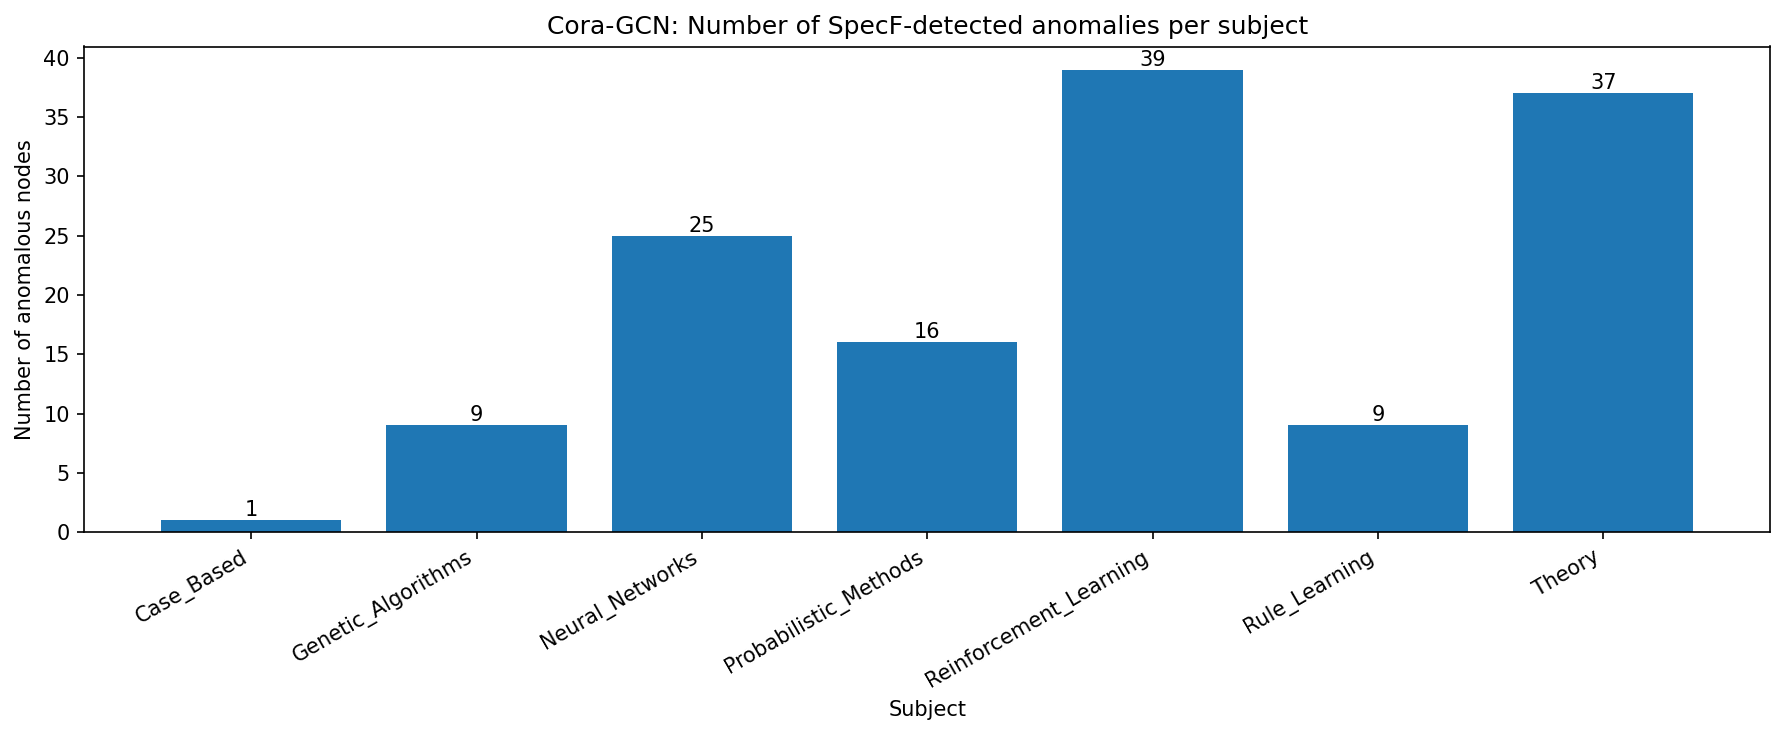

In [23]:
# ----------------------------------
# Build per-subject stats (counts)
# ----------------------------------
stats_subj = (
    df_results
    .assign(is_specf_anom=df_results["node_id"].isin(specf_set))
    .groupby("subject_name")["is_specf_anom"]
    .agg(total="count", anom="sum")
    .reset_index()
)

# ----------------------------------
# Plot anomaly COUNTS
# ----------------------------------
fig = plt.figure(figsize=(12, 5), dpi=150)

bars = plt.bar(stats_subj["subject_name"], stats_subj["anom"])

# add numbers on bars
for bar, val in zip(bars, stats_subj["anom"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        str(int(val)),
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xlabel("Subject")
plt.ylabel("Number of anomalous nodes")
plt.title("Cora-GCN: Number of SpecF-detected anomalies per subject")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


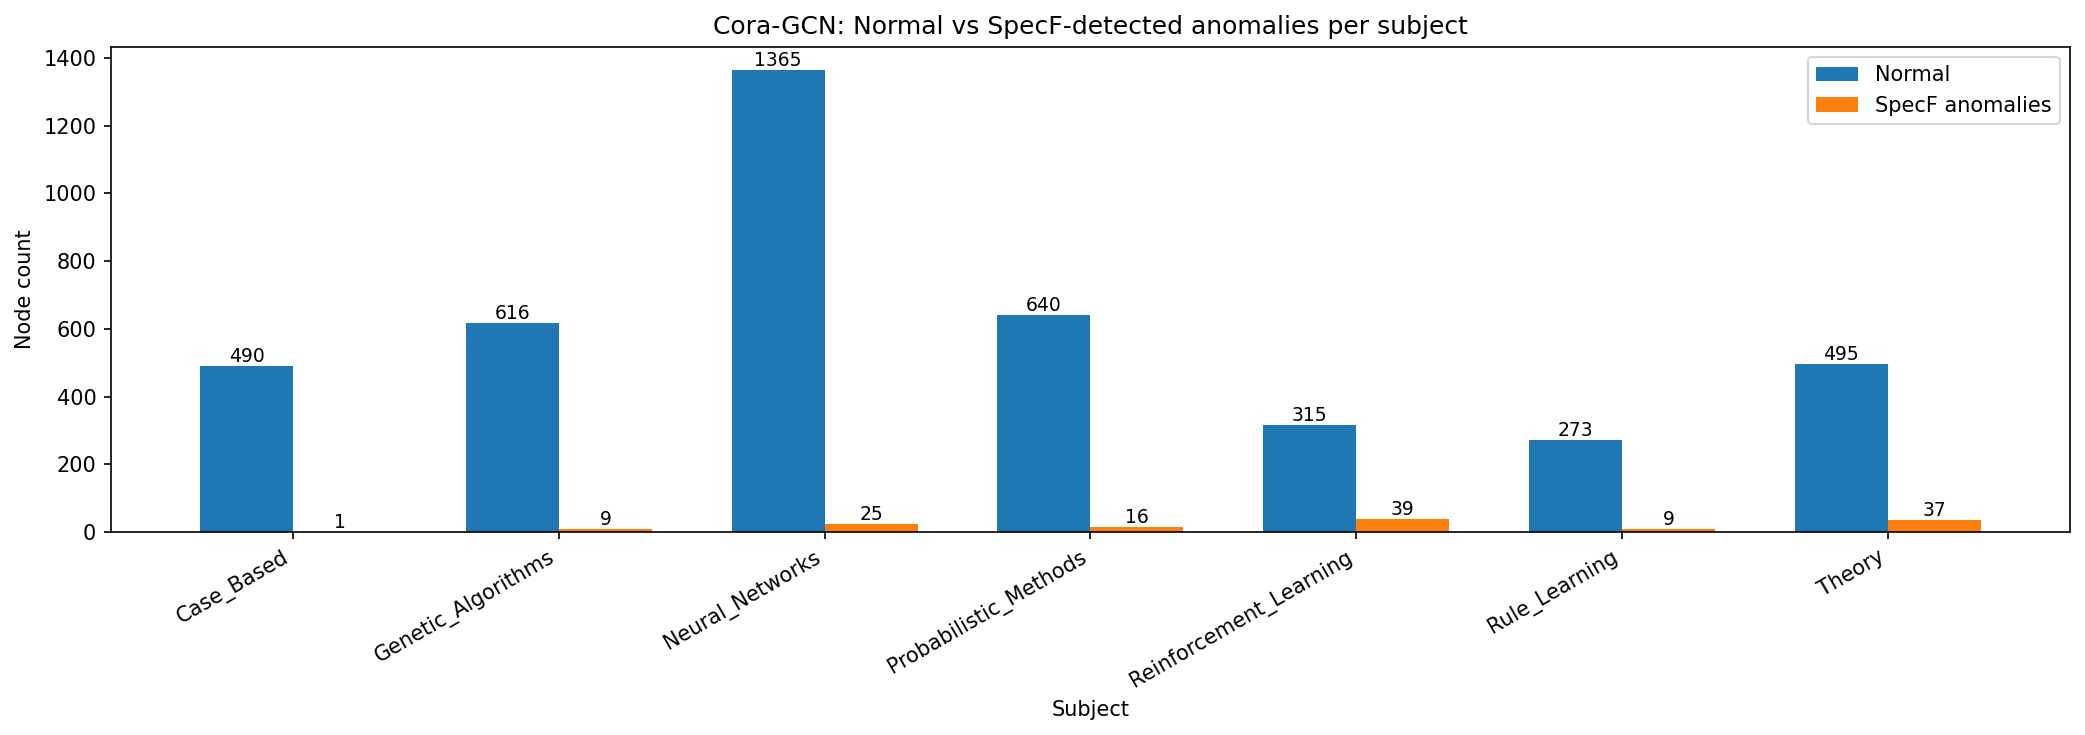

Saved plot to: /content/Results/Normal_vs_SpecF_anomalies_per_subject.png


In [24]:
# add normal count
stats_subj["normal"] = stats_subj["total"] - stats_subj["anom"]

x = np.arange(len(stats_subj))
width = 0.35

# --------------------------------------------------
# Results folder
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "Normal_vs_SpecF_anomalies_per_subject.png"

# --------------------------------------------------
# Plot
# --------------------------------------------------
fig = plt.figure(figsize=(14, 5), dpi=150)

bars_normal = plt.bar(x - width/2, stats_subj["normal"], width, label="Normal")
bars_anom   = plt.bar(x + width/2, stats_subj["anom"],   width, label="SpecF anomalies")

# -------------------------------------------------
# add numbers on bars
# -------------------------------------------------
for bar in bars_normal:
    h = bar.get_height()
    if h > 0:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            h,
            str(int(h)),
            ha="center",
            va="bottom",
            fontsize=9
        )
for bar in bars_anom:
    h = bar.get_height()
    if h > 0:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            h,
            str(int(h)),
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.xticks(x, stats_subj["subject_name"], rotation=30, ha="right")
plt.xlabel("Subject")
plt.ylabel("Node count")
plt.title("Cora-GCN: Normal vs SpecF-detected anomalies per subject")
plt.legend()
plt.tight_layout()

# Save under Results
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")


# Count NORMAL vs ANOMALOUS per community

In [25]:
stats = defaultdict(lambda: {
    "total": 0,
    "normal": 0,
    "anomalous": 0
})

for i in range(len(df_results)):
    comm = df_results.loc[i, "community_id"]

    stats[comm]["total"] += 1

    if i in specf_set:
        stats[comm]["anomalous"] += 1
    else:
        stats[comm]["normal"] += 1


print("\nCommunity-wise normal vs anomalous nodes (SpecF):\n")
print(f"{'Community':>9s} | {'Total':>5s} | {'Normal':>6s} | {'Anom':>5s} | {'Anom %':>7s}")
print("-"*60)

for comm in sorted(stats.keys()):
    s = stats[comm]
    total = s["total"]
    anom = s["anomalous"]
    normal = s["normal"]
    pct = 100.0 * anom / total if total > 0 else 0.0

    print(f"{comm:9d} | "
          f"{total:5d} | {normal:6d} | {anom:5d} | {pct:6.2f}%")



Community-wise normal vs anomalous nodes (SpecF):

Community | Total | Normal |  Anom |  Anom %
------------------------------------------------------------
        0 |   584 |    571 |    13 |   2.23%
        1 |   400 |    384 |    16 |   4.00%
        2 |   428 |    413 |    15 |   3.50%
        3 |   380 |    360 |    20 |   5.26%
        4 |   475 |    459 |    16 |   3.37%
        5 |  1169 |   1135 |    34 |   2.91%
        6 |   894 |    872 |    22 |   2.46%


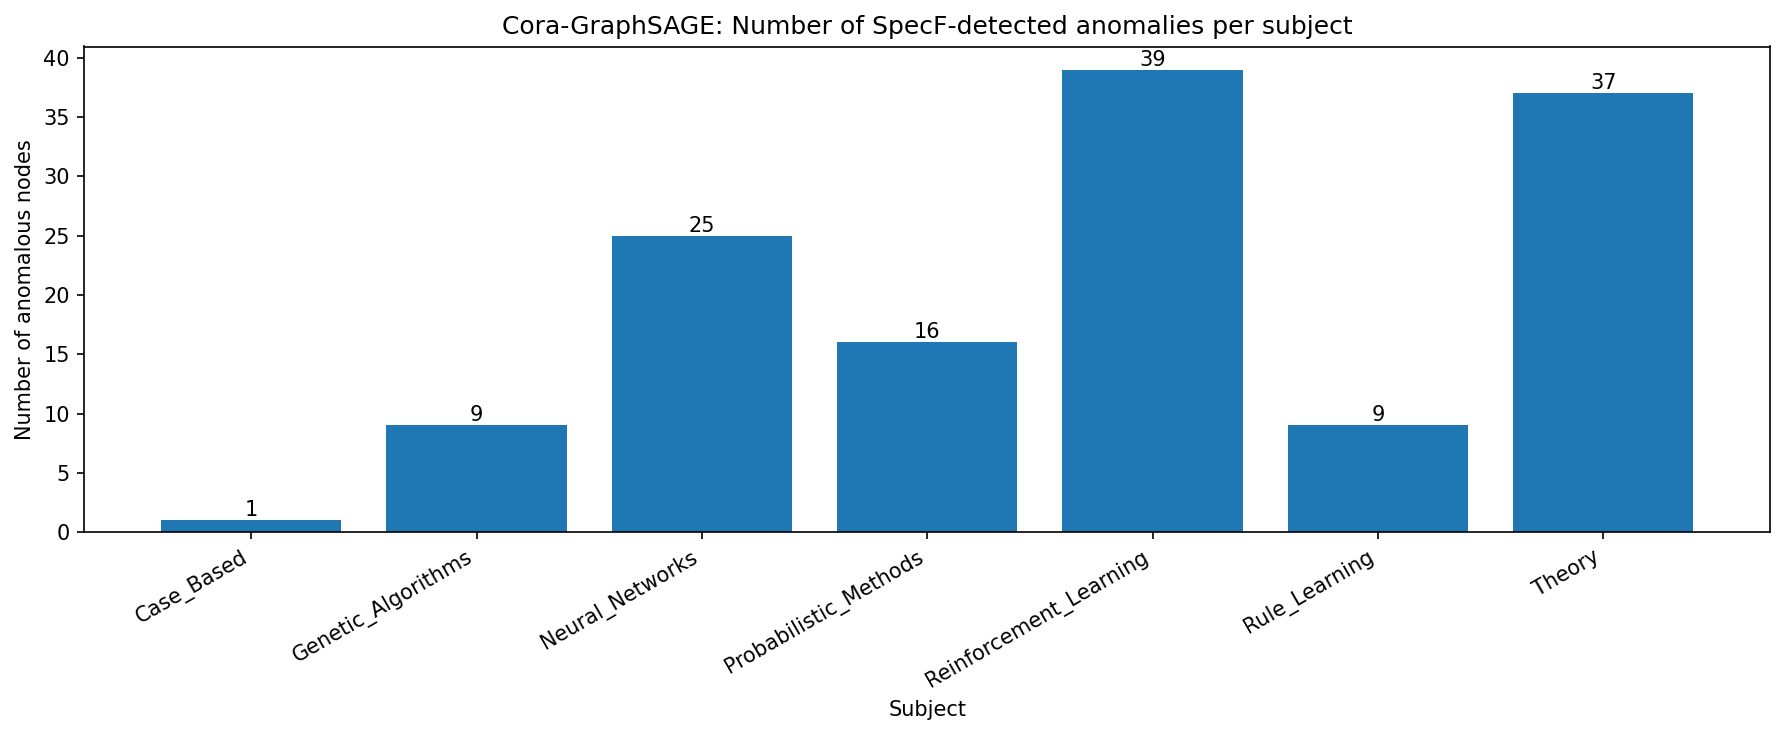

In [26]:
# ----------------------------------
# Build per-subject stats (counts)
# ----------------------------------
stats_subj = (
    df_results
    .assign(is_specf_anom=df_results["node_id"].isin(specf_set))
    .groupby("subject_name")["is_specf_anom"]
    .agg(total="count", anom="sum")
    .reset_index()
)

# ----------------------------------
# Plot anomaly COUNTS
# ----------------------------------
fig = plt.figure(figsize=(12, 5), dpi=150)

bars = plt.bar(stats_subj["subject_name"], stats_subj["anom"])

# add numbers on bars
for bar, val in zip(bars, stats_subj["anom"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        str(int(val)),
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xlabel("Subject")
plt.ylabel("Number of anomalous nodes")
plt.title("Cora-GraphSAGE: Number of SpecF-detected anomalies per subject")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


Vizualize

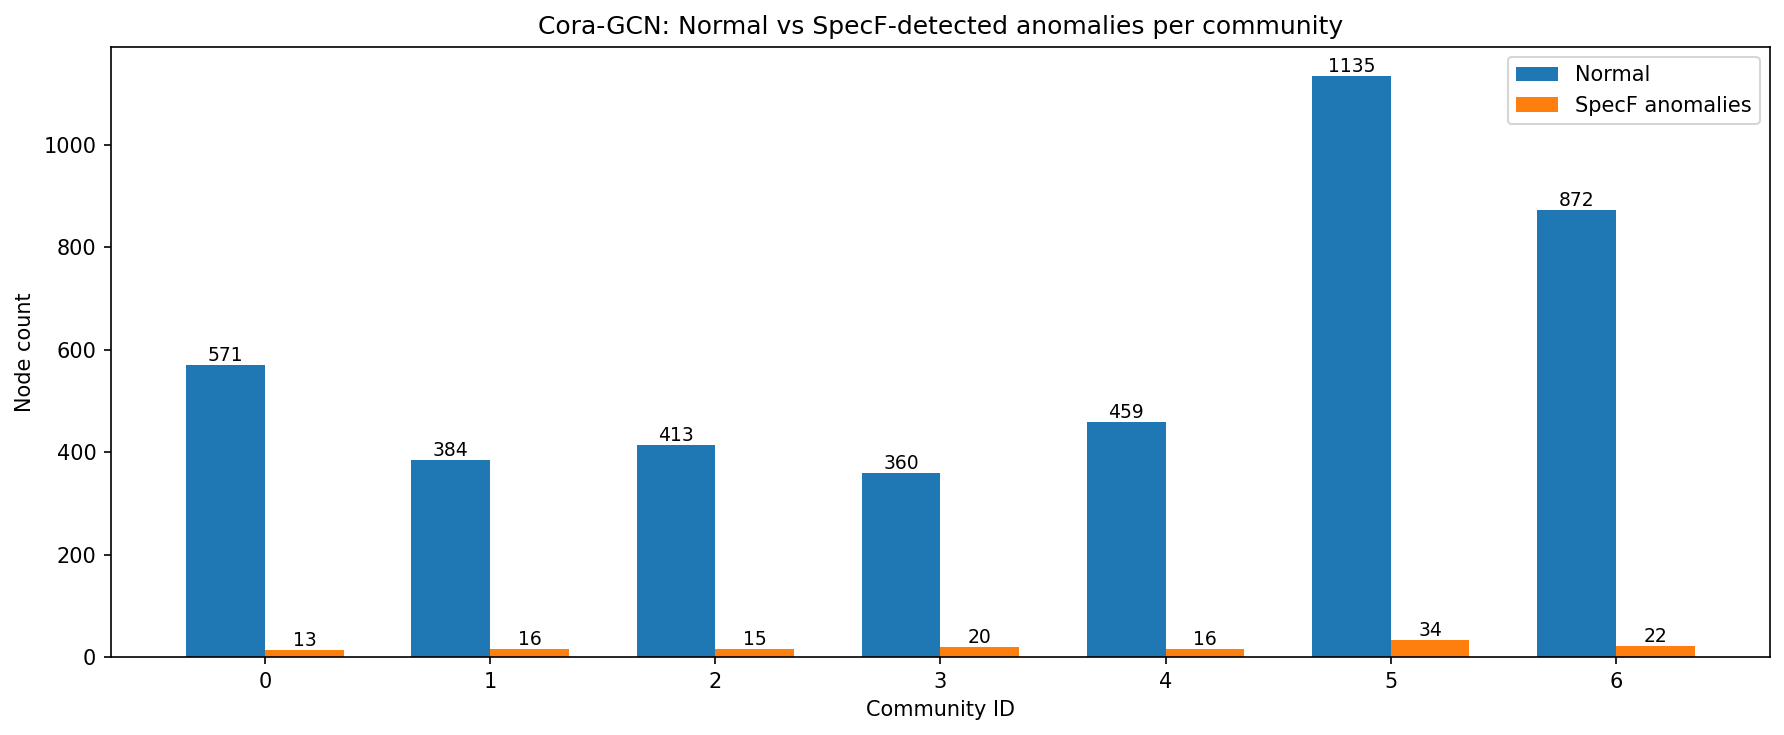

Saved plot to: /content/Results/Normal_vs_SpecF_anomalies_per_community.png


In [27]:
# communities (sorted, numeric)
comms = sorted(stats.keys())

normal_vals = [stats[c]["normal"] for c in comms]
anom_vals   = [stats[c]["anomalous"] for c in comms]

x = np.arange(len(comms))
width = 0.35

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "Normal_vs_SpecF_anomalies_per_community.png"


fig = plt.figure(figsize=(12, 5), dpi=150)

bars_normal = plt.bar(x - width/2, normal_vals, width, label="Normal")
bars_anom   = plt.bar(x + width/2, anom_vals,   width, label="SpecF anomalies")

# -----------------------------
# add numbers on bars
# -----------------------------
for bar in bars_normal:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        h,
        str(int(h)),
        ha="center",
        va="bottom",
        fontsize=9
    )

for bar in bars_anom:
    h = bar.get_height()
    if h > 0:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            h,
            str(int(h)),
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.xticks(x, comms)
plt.xlabel("Community ID")
plt.ylabel("Node count")
plt.title("Cora-GCN: Normal vs SpecF-detected anomalies per community")
plt.legend()
plt.tight_layout()

# Save under Results
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")

# Visualize ANOMALOUS nodes per community

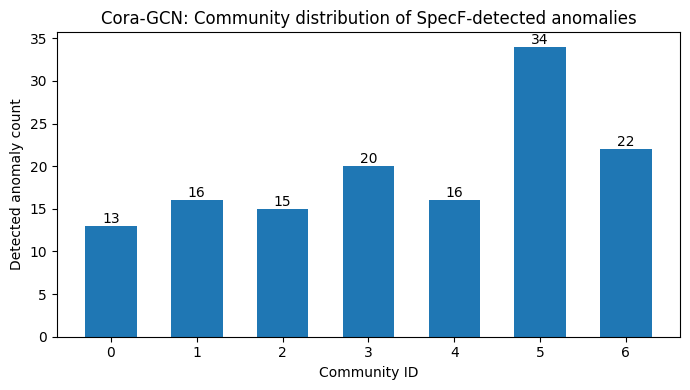

In [28]:
# Communities of SpecF-detected anomalies
detected_comms = [clusters_dict[n] for n in specf_set]
detected_cnt = Counter(detected_comms)

all_comms = sorted(detected_cnt)
x = np.arange(len(all_comms))
vals = [detected_cnt[c] for c in all_comms]

plt.figure(figsize=(7,4))
bars = plt.bar(x, vals, width=0.6)

# Add numbers on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xticks(x, all_comms)
plt.xlabel("Community ID")
plt.ylabel("Detected anomaly count")
plt.title("Cora-GCN: Community distribution of SpecF-detected anomalies")
plt.tight_layout()
plt.show()


# Per-community distribution of SpecF spectral deviation scores

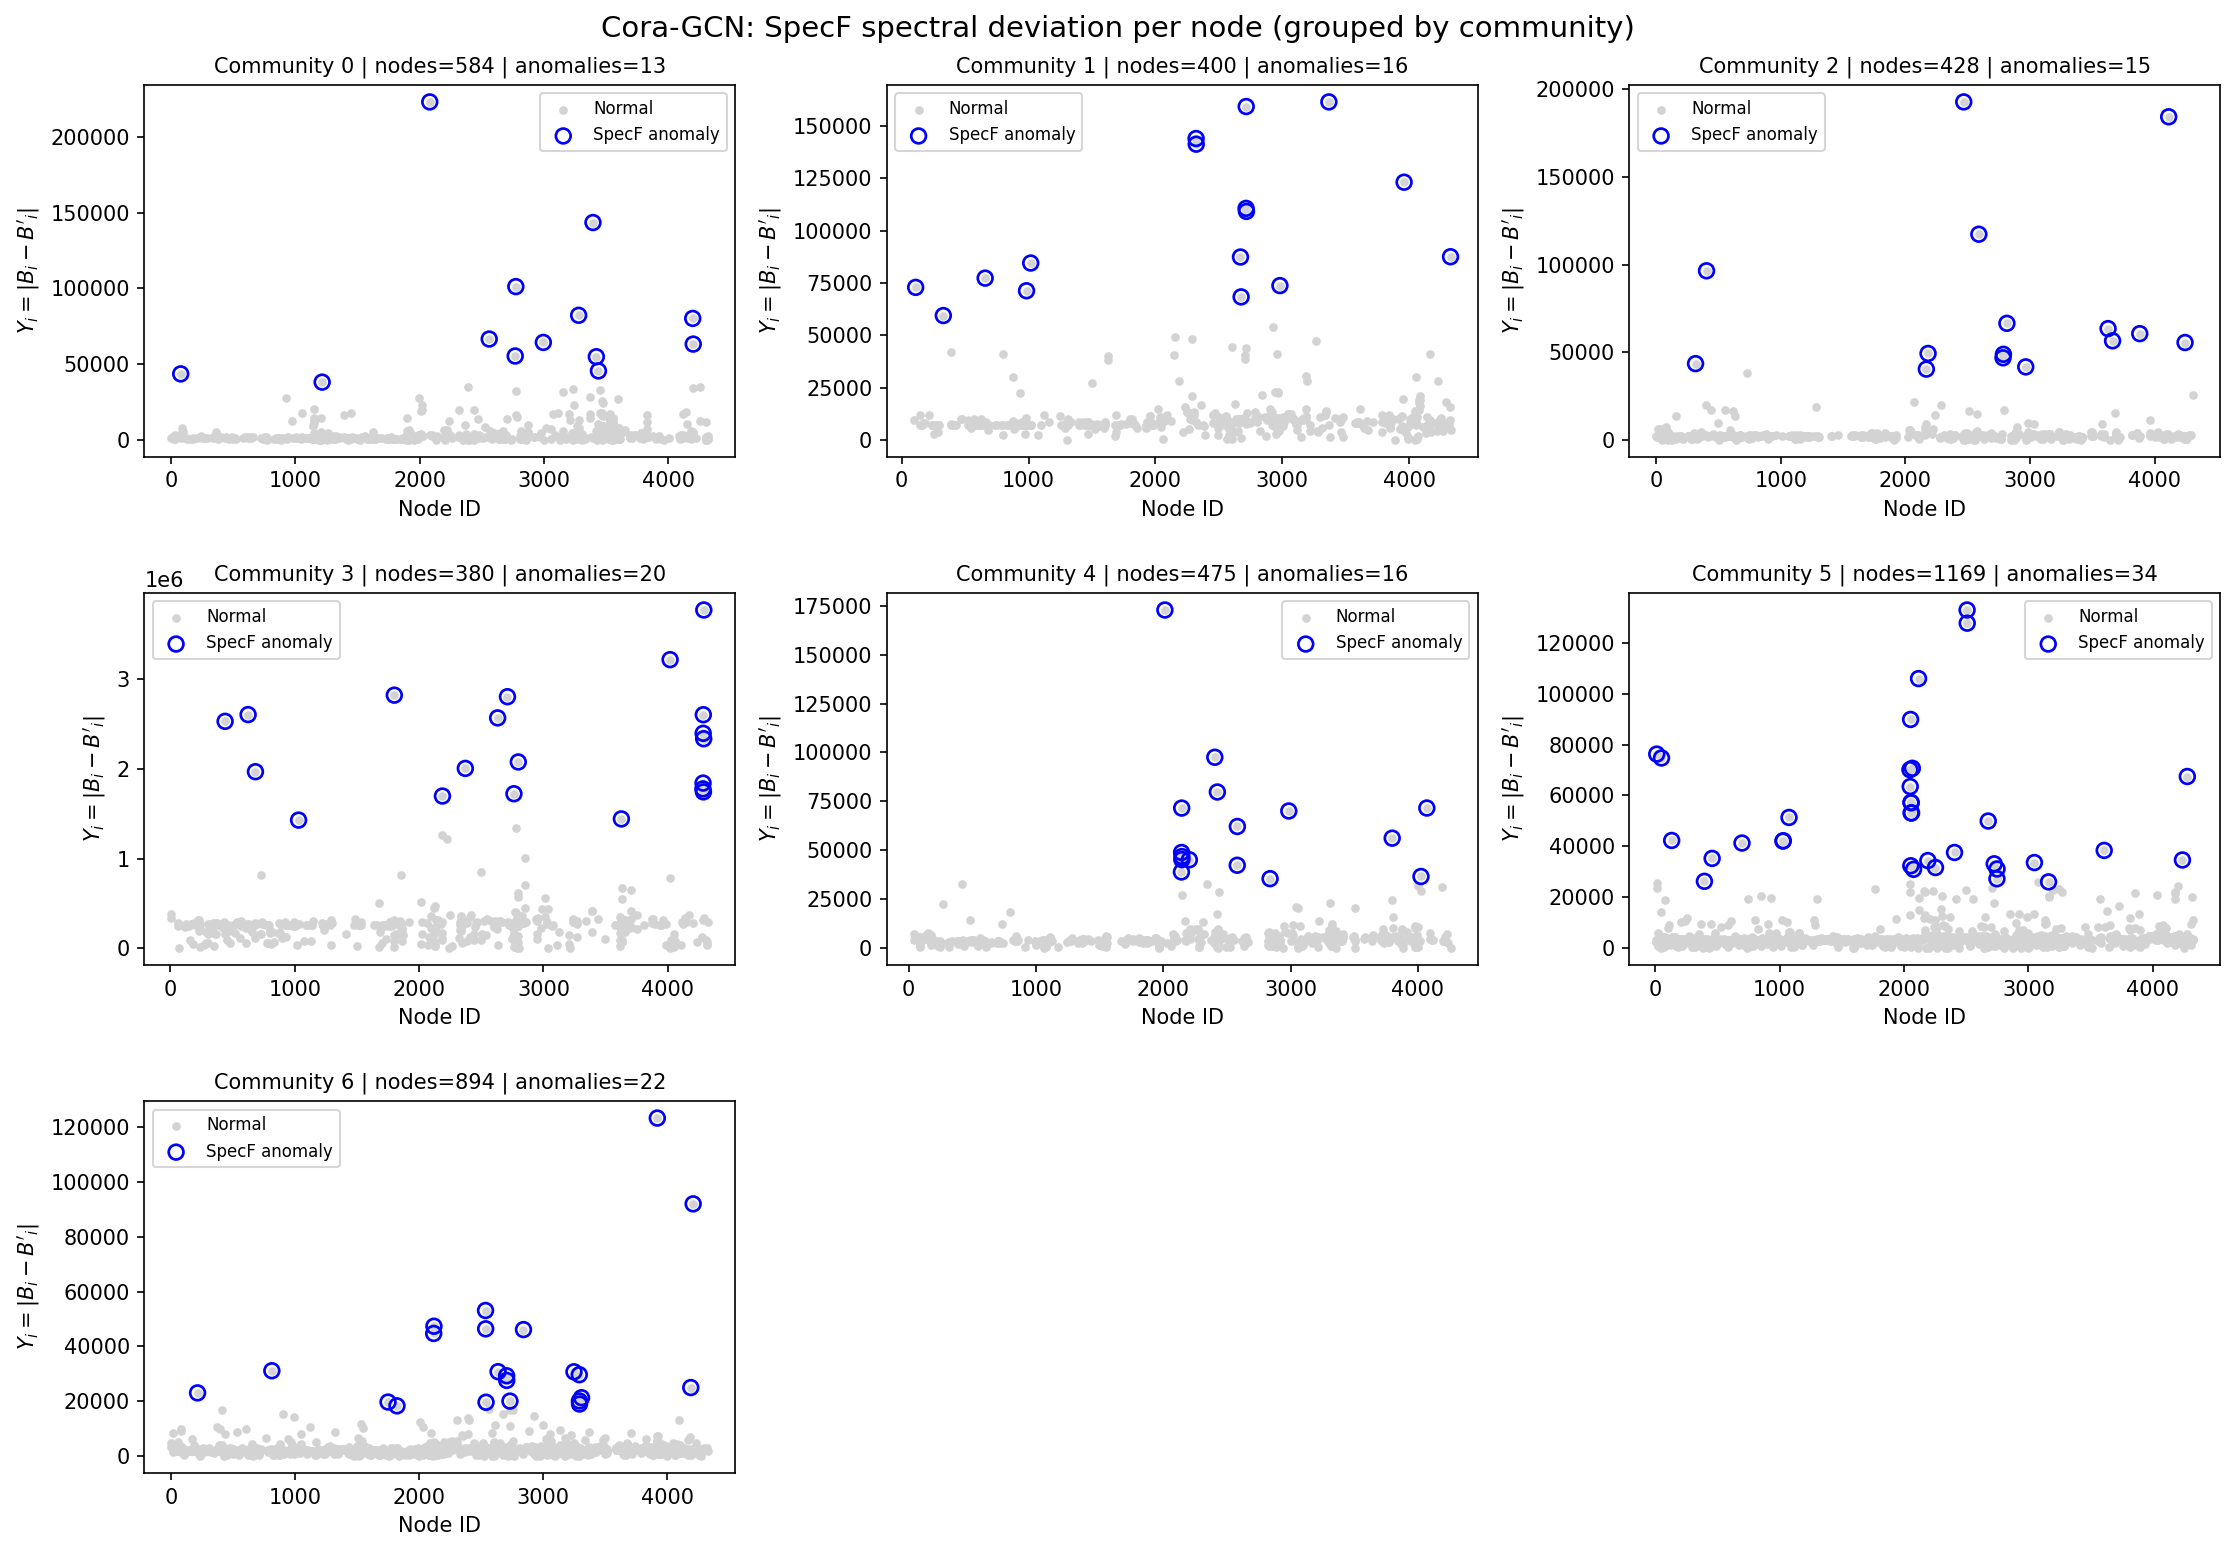

Saved single-page figure to: /content/Results/SpecF_scores_per_community.png


In [29]:
# -------------------------------------------------
# 1. Prepare arrays (node_id = 0..N-1 assumed)
# -------------------------------------------------
N = len(B)

vals_Y = np.array([Y_scores[i] for i in range(N)], dtype=float)
comm_ids = np.array([clusters_dict[i] for i in range(N)])
specf_set = set(specf_anomalies)

# all communities
all_comms = np.sort(np.unique(comm_ids))

# -------------------------------------------------
# 2. Plot settings
# -------------------------------------------------
cols = 3
rows = math.ceil(len(all_comms) / cols)
plots_per_fig = 9
num_figs = math.ceil(len(all_comms) / plots_per_fig)

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "SpecF_scores_per_community.png"

# -------------------------------------------------
# 3. Plot per community
# -------------------------------------------------
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3.5), dpi=150)
axes = np.array(axes).reshape(-1)

for ax_i, c in enumerate(all_comms):
    ax = axes[ax_i]

    idx = np.where(comm_ids == c)[0]
    idx_anom = np.array([i for i in idx if int(i) in specf_set], dtype=int)

    ax.scatter(idx, vals_Y[idx], s=10, color="lightgray", label="Normal")

    if len(idx_anom) > 0:
        ax.scatter(
            idx_anom,
            vals_Y[idx_anom],
            s=50,
            facecolors="none",
            edgecolors="blue",
            linewidths=1.3,
            label="SpecF anomaly"
        )

    ax.set_title(
        f"Community {c} | nodes={len(idx)} | anomalies={len(idx_anom)}",
        fontsize=10
    )
    ax.set_xlabel("Node ID")
    ax.set_ylabel(r"$Y_i = |B_i - B'_i|$")
    ax.legend(fontsize=8)

# remove unused subplots
for j in range(len(all_comms), len(axes)):
    axes[j].axis("off")

fig.suptitle(
    "Cora-GCN: SpecF spectral deviation per node (grouped by community)",
    fontsize=14
)
fig.tight_layout()

# Save under Results
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved single-page figure to: {out_png.resolve()}")

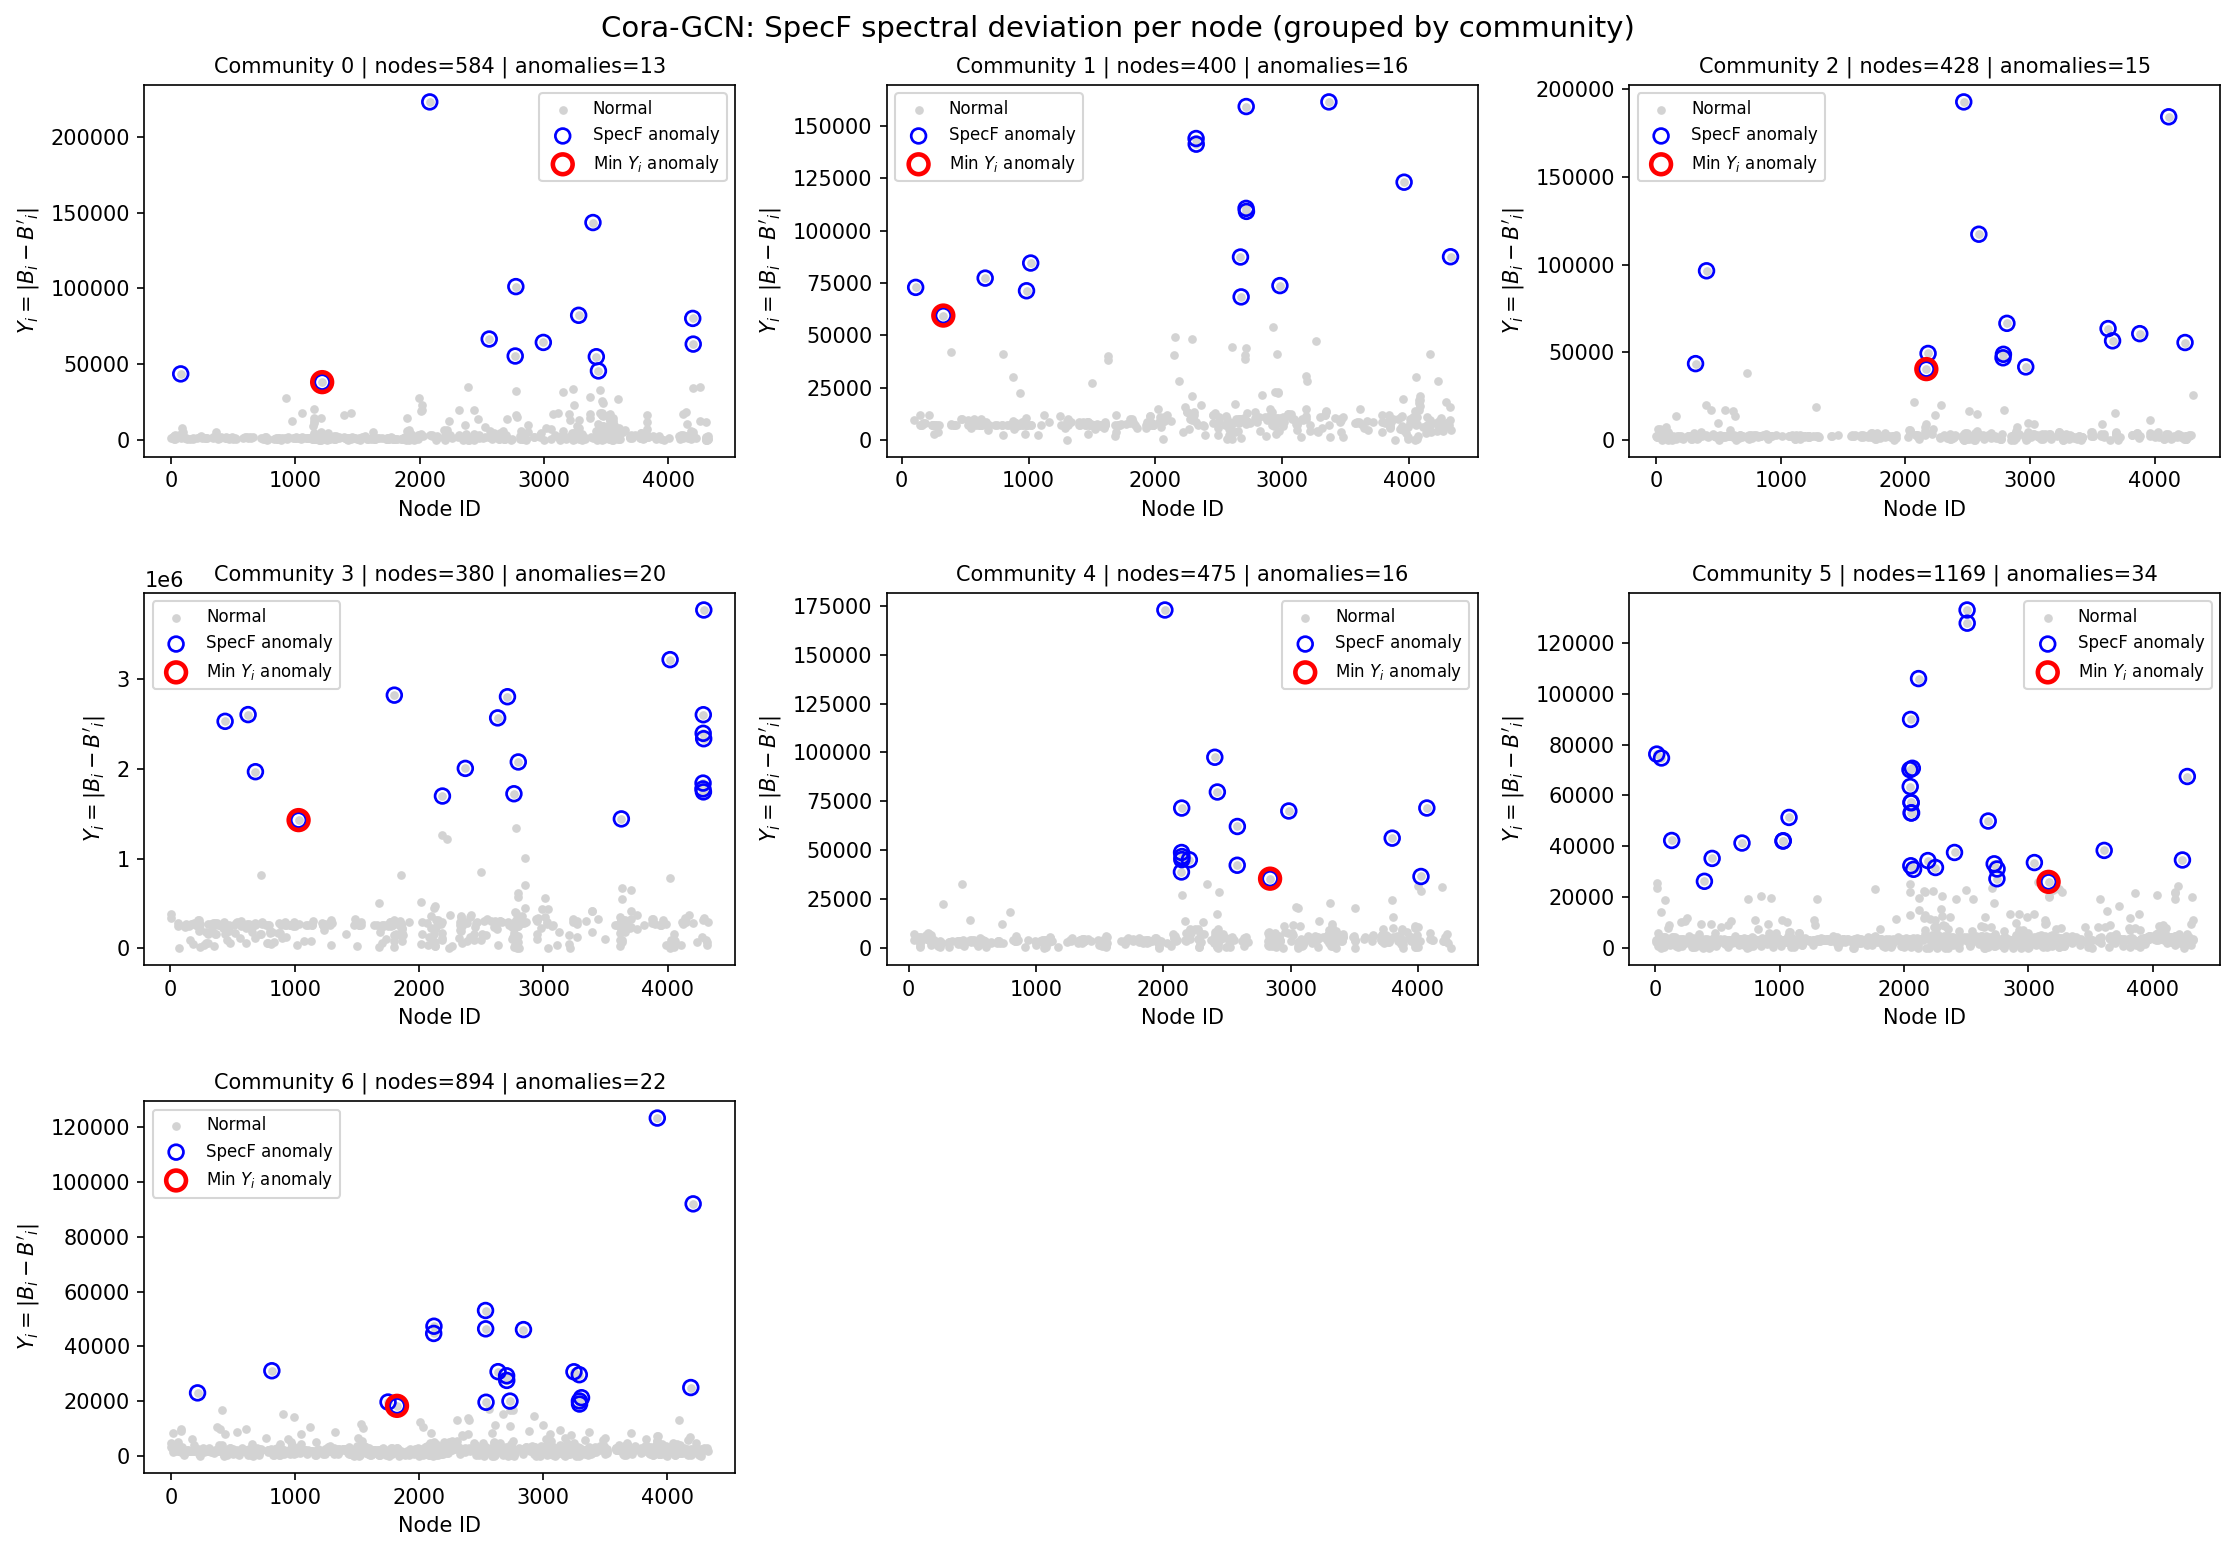

Saved figure to: /content/Results/SpecF_scores_per_community_minYi_highlighted.png


In [30]:
# -------------------------------------------------
# 1. Prepare arrays (node_id = 0..N-1 assumed)
# -------------------------------------------------
N = len(B)

vals_Y = np.array([Y_scores[i] for i in range(N)], dtype=float)
comm_ids = np.array([clusters_dict[i] for i in range(N)], dtype=int)
specf_set = set(map(int, specf_anomalies))

all_comms = np.sort(np.unique(comm_ids))

# -------------------------------------------------
# 2. Plot settings (single-page)
# -------------------------------------------------
cols = 3
rows = math.ceil(len(all_comms) / cols)

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "SpecF_scores_per_community_minYi_highlighted.png"

# -------------------------------------------------
# 3. Plot per community + highlight min-Y anomaly in RED
# -------------------------------------------------
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3.5), dpi=150)
axes = np.array(axes).reshape(-1)

for ax_i, c in enumerate(all_comms):
    ax = axes[ax_i]

    # nodes in this community
    idx = np.where(comm_ids == c)[0]

    # anomalies in this community
    idx_anom = np.array([i for i in idx if int(i) in specf_set], dtype=int)

    # plot all nodes (gray)
    ax.scatter(idx, vals_Y[idx], s=10, color="lightgray", label="Normal")

    if len(idx_anom) > 0:
        # plot all anomalies (blue circles)
        ax.scatter(
            idx_anom,
            vals_Y[idx_anom],
            s=50,
            facecolors="none",
            edgecolors="blue",
            linewidths=1.3,
            label="SpecF anomaly"
        )

        # find anomaly with smallest Yi in this community
        min_pos = np.argmin(vals_Y[idx_anom])
        min_node = idx_anom[min_pos]

        # highlight it in red circle border
        ax.scatter(
            [min_node],
            [vals_Y[min_node]],
            s=90,
            facecolors="none",
            edgecolors="red",
            linewidths=2.2,
            label="Min $Y_i$ anomaly"
        )

    ax.set_title(
        f"Community {c} | nodes={len(idx)} | anomalies={len(idx_anom)}",
        fontsize=10
    )
    ax.set_xlabel("Node ID")
    ax.set_ylabel(r"$Y_i = |B_i - B'_i|$")

    # Avoid legend clutter: only show unique labels per subplot
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), fontsize=8)

# remove unused subplots
for j in range(len(all_comms), len(axes)):
    axes[j].axis("off")

fig.suptitle("Cora-GCN: SpecF spectral deviation per node (grouped by community)", fontsize=14)
fig.tight_layout()

# Save under Results
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved figure to: {out_png.resolve()}")


# visualization of SpecF-detected anomalies per community

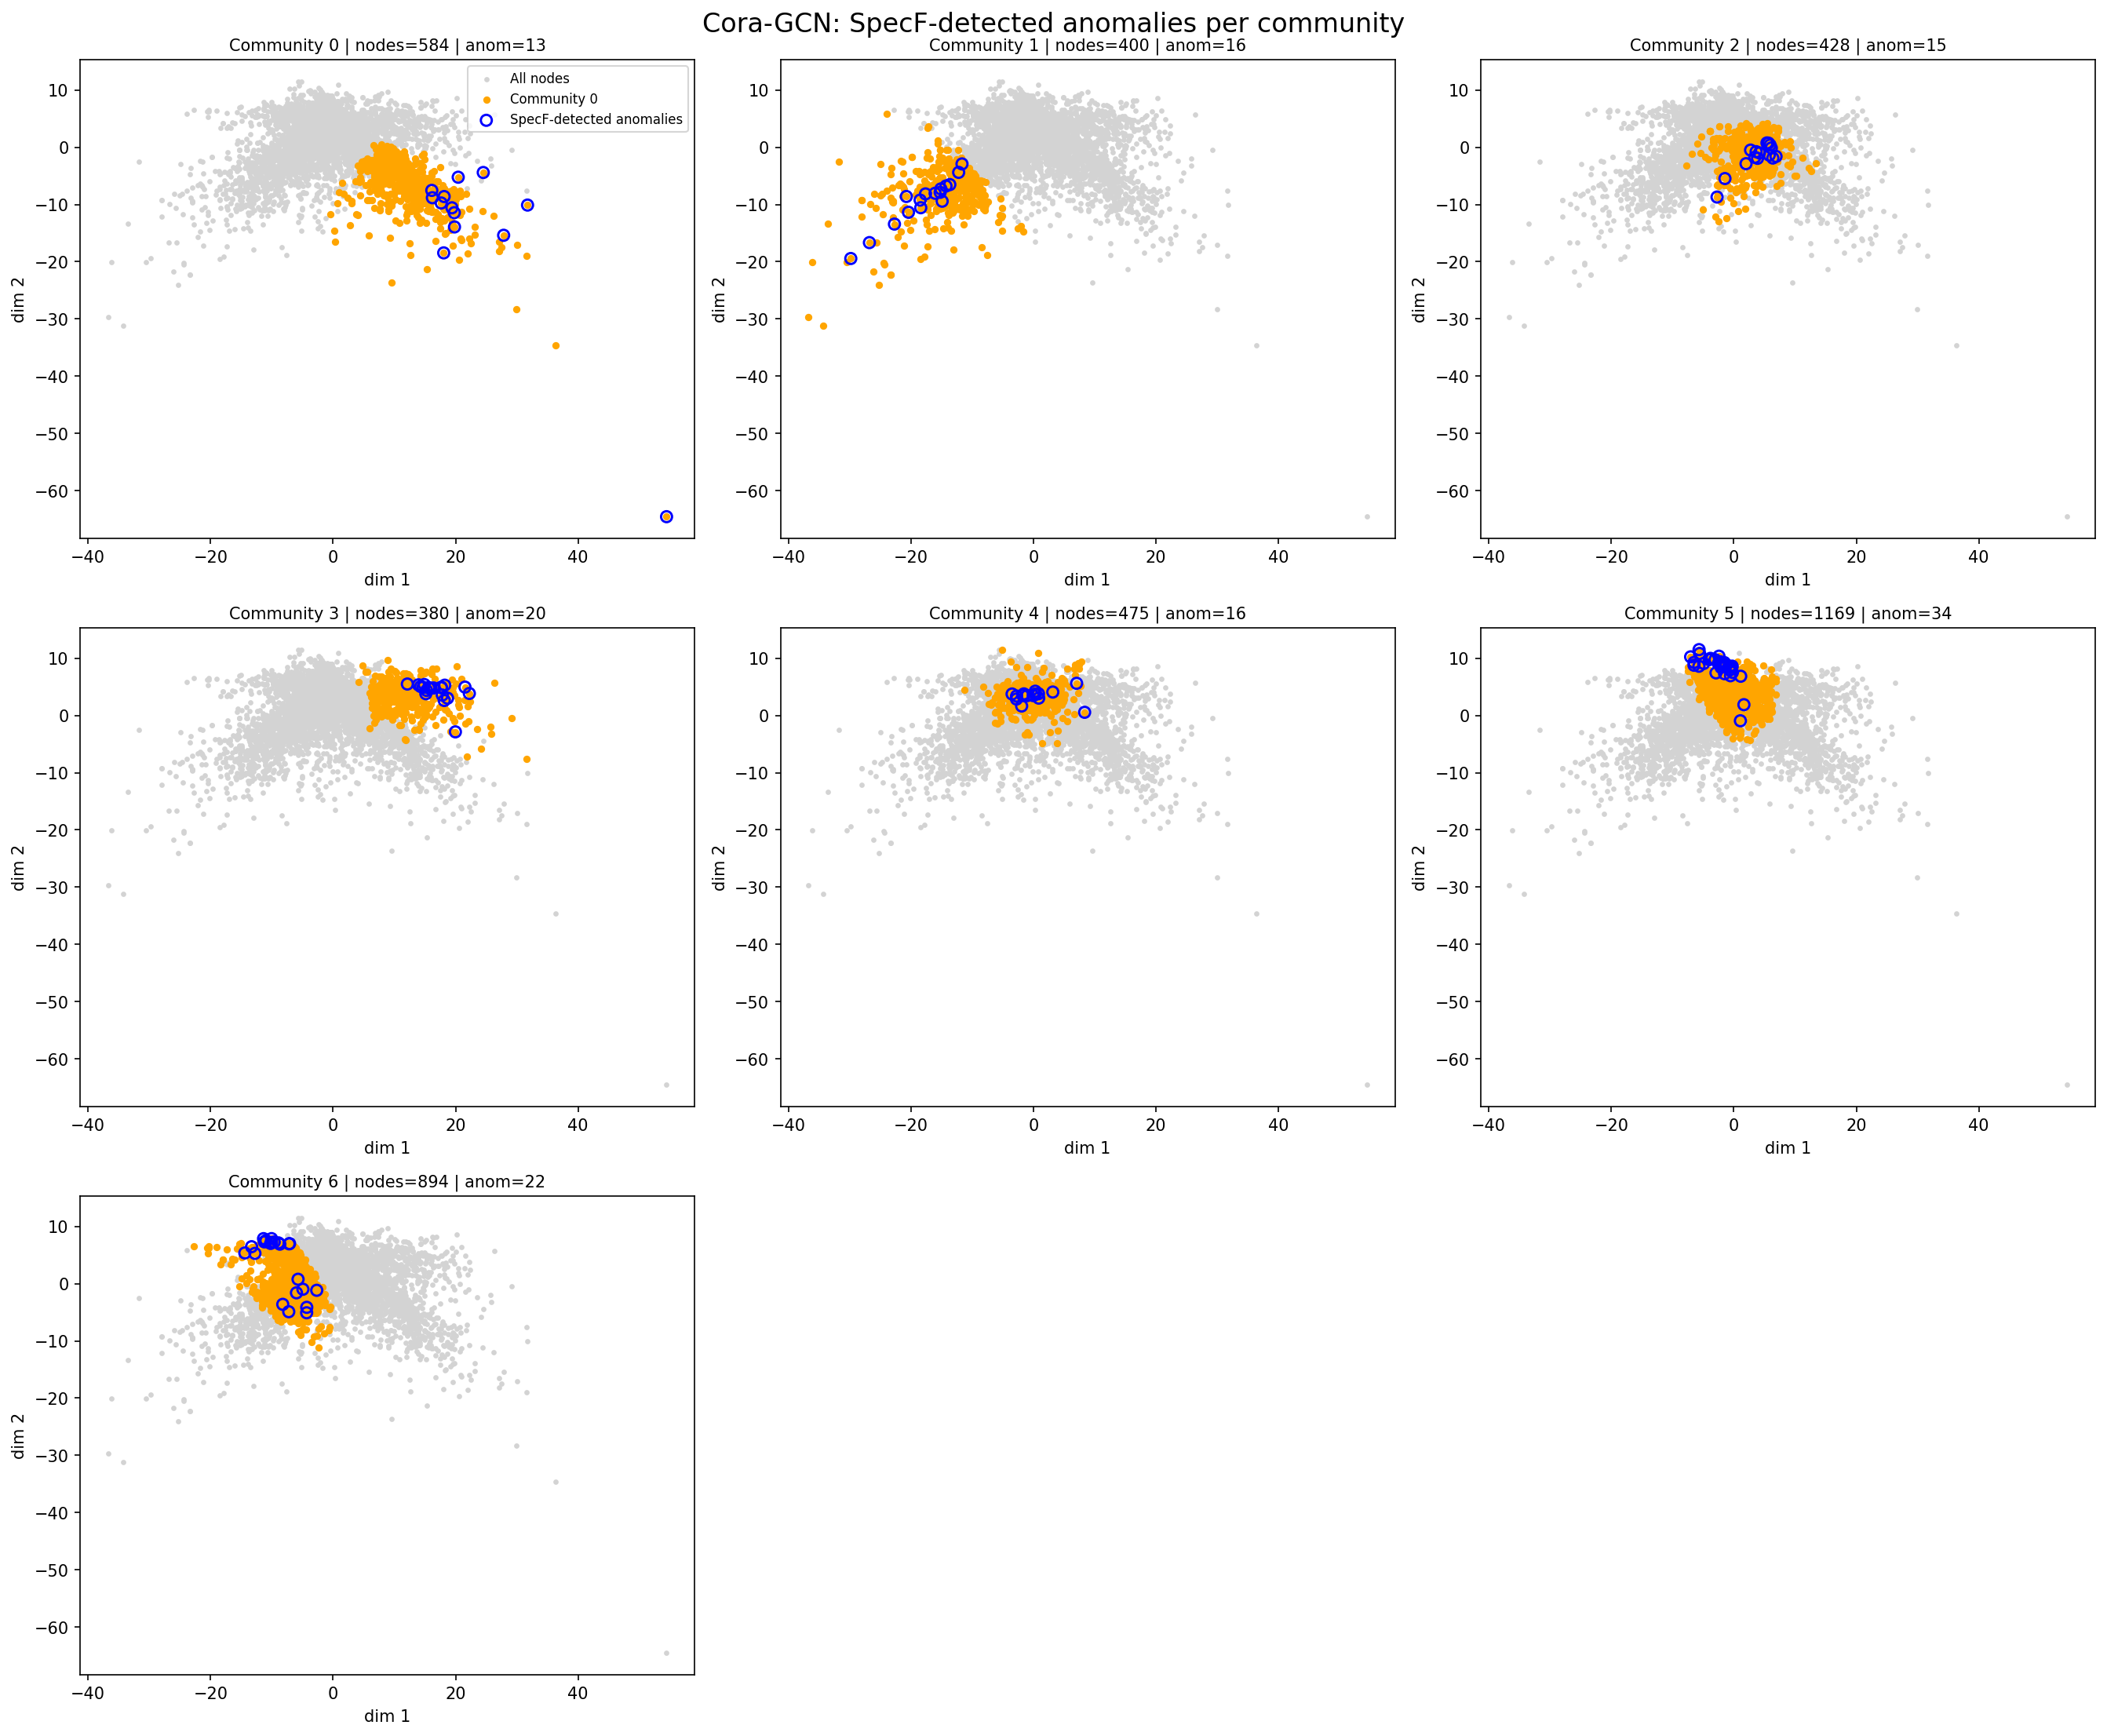

Saved plot to: /content/Results/SpecF_detected_anomalies_per_community.png


In [31]:
N = len(node_order)
specf_set = set(specf_anomalies)

# SpecF anomaly mask (global)
mask_anom = np.zeros(N, dtype=bool)
mask_anom[list(specf_set)] = True

# community id per node (aligned with X2 indexing)
comm_ids = np.array([clusters_dict[i] for i in range(N)])
all_comms = np.sort(np.unique(comm_ids))

cols = 3
rows = math.ceil(len(all_comms) / cols)

# --------------------------------------------------
# Results folder
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "SpecF_detected_anomalies_per_community.png"



fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5), dpi=150)
axes = np.array(axes).reshape(-1)

for ax_i, community_to_show in enumerate(all_comms):
    ax = axes[ax_i]

    # masks for this community
    mask_comm = (comm_ids == community_to_show)
    mask_comm_anom = mask_comm & mask_anom

    # background: all nodes
    ax.scatter(X2[:, 0], X2[:, 1], s=5, color="lightgray", label="All nodes")

    # highlight community nodes
    ax.scatter(
        X2[mask_comm, 0], X2[mask_comm, 1],
        s=12, color="orange", label=f"Community {community_to_show}"
    )

    # anomalies in this community
    if mask_comm_anom.sum() > 0:
        ax.scatter(
            X2[mask_comm_anom, 0], X2[mask_comm_anom, 1],
            s=45, edgecolors="blue", facecolors="none",
            linewidths=1.4, label="SpecF-detected anomalies"
        )

    ax.set_title(
        f"Community {community_to_show} | nodes={mask_comm.sum()} | anom={mask_comm_anom.sum()}",
        fontsize=10
    )
    ax.set_xlabel("dim 1")
    ax.set_ylabel("dim 2")

    # show legend only in the first subplot
    if ax_i == 0:
        ax.legend(loc="upper right", fontsize=8)

# turn off empty subplots
for j in range(len(all_comms), len(axes)):
    axes[j].axis("off")

fig.suptitle("Cora-GCN: SpecF-detected anomalies per community", fontsize=16)
plt.tight_layout()

# --------------------------------------------------
# Save under Results
# --------------------------------------------------
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")

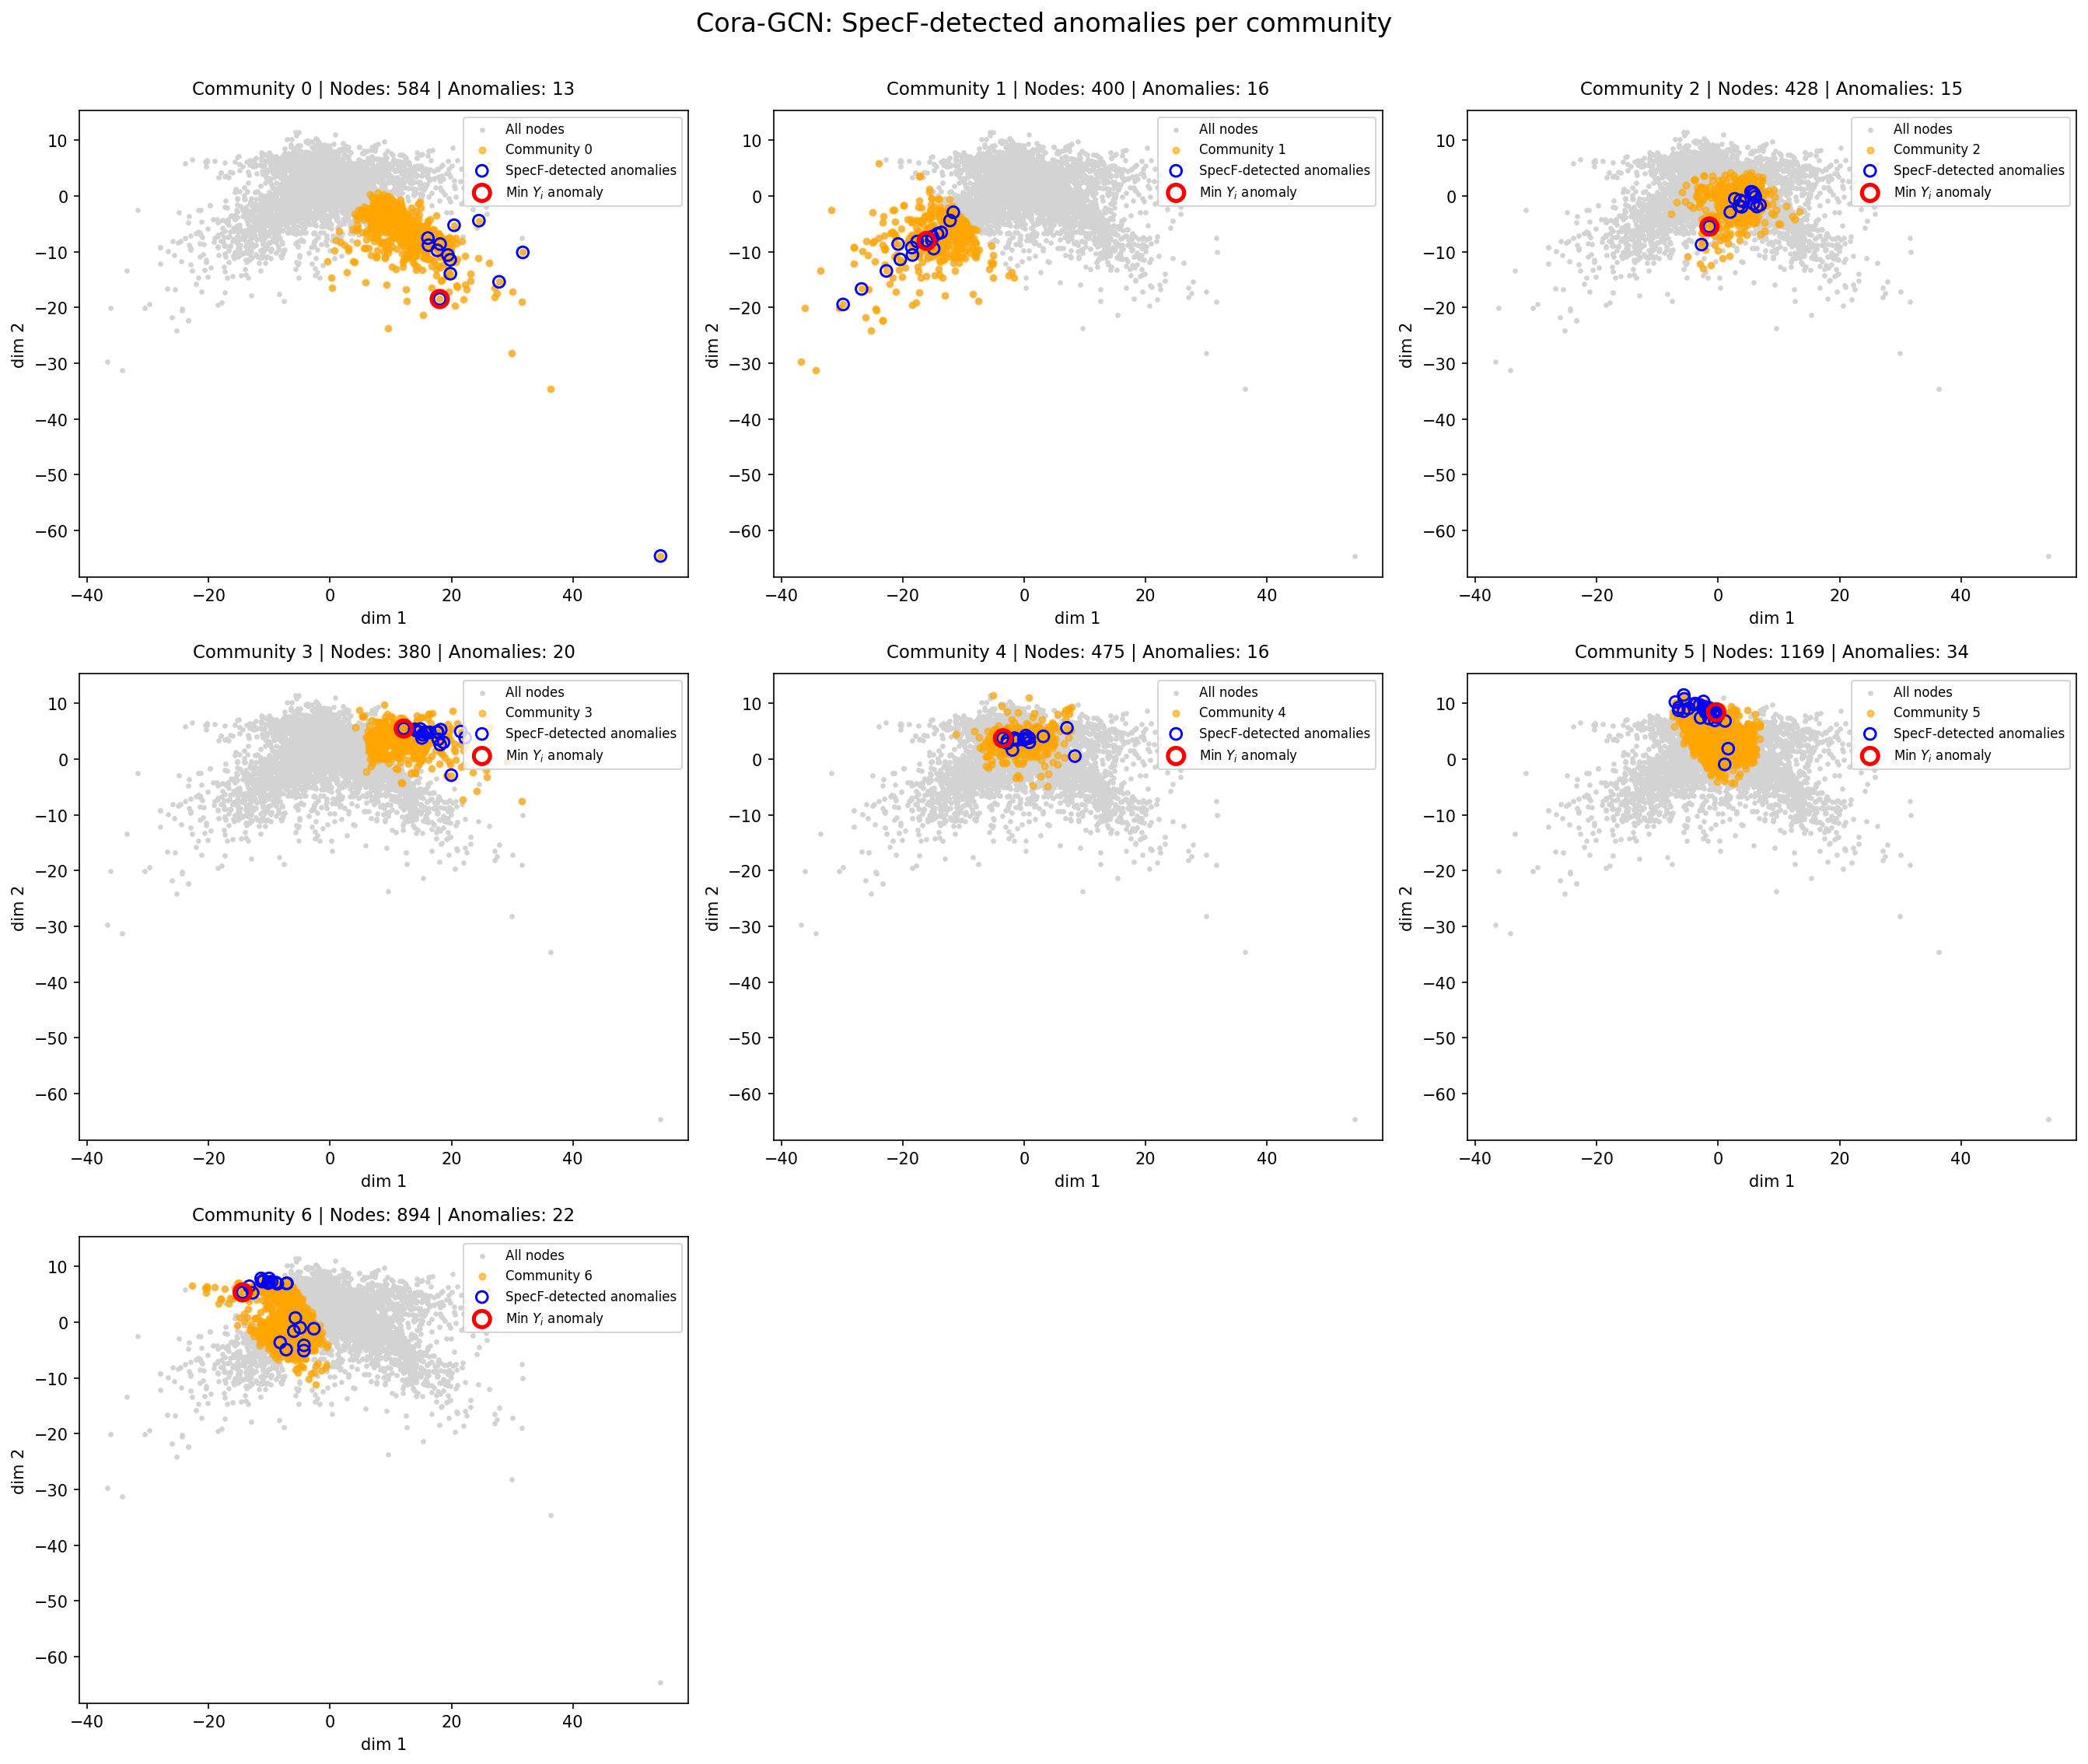

plot saved to: /content/Results/SpecF_detected_anomalies_per_community_minYi_highlighted.png


In [32]:
# --------------------------------------------------
# 1. Prepare Data Alignment
# --------------------------------------------------
# Use the length of your actual OpenAlex data object
N = data.num_nodes
specf_set = set(map(int, specf_anomalies))

# Global anomaly mask
mask_anom = np.zeros(N, dtype=bool)
mask_anom[list(specf_set)] = True

# Community ID per node (ensure it aligns with PCA matrix X2)
comm_ids = np.array([clusters_dict[i] for i in range(N)], dtype=int)
all_comms = np.sort(np.unique(comm_ids))

# Deviation scores for highlighting edge cases
vals_Y = np.array([Y_scores[i] for i in range(N)], dtype=float)

# --------------------------------------------------
# 2. Layout & Export Settings
# --------------------------------------------------
cols = 3
rows = math.ceil(len(all_comms) / cols)

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
out_png = RESULTS_DIR / "SpecF_detected_anomalies_per_community_minYi_highlighted.png"

# --------------------------------------------------
# 3. Plotting the Community PCA Grid
# --------------------------------------------------
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5), dpi=150)
axes = np.array(axes).reshape(-1)

for ax_i, community_to_show in enumerate(all_comms):
    ax = axes[ax_i]

    # Filters for this specific community
    mask_comm = (comm_ids == community_to_show)
    mask_comm_anom = mask_comm & mask_anom

    # A. Background: All other papers in the graph (Light Grey)
    ax.scatter(X2[:, 0], X2[:, 1], s=5, color="lightgray", label="All nodes")

    # B. Community Nodes: The orange "cluster" of papers
    ax.scatter(
        X2[mask_comm, 0], X2[mask_comm, 1],
        s=15, color="orange", alpha=0.6, label=f"Community {community_to_show}"
    )

    # C. Anomalies: Blue circles for all flagged outliers
    if mask_comm_anom.sum() > 0:
        ax.scatter(
            X2[mask_comm_anom, 0], X2[mask_comm_anom, 1],
            s=50, edgecolors="blue", facecolors="none",
            linewidths=1.4, label="SpecF-detected anomalies"
        )

        # D. Borderline Anomaly: The red highlight (lowest deviation score)
        # This identifies the "subtlest" outlier in the cluster
        anom_idx = np.where(mask_comm_anom)[0]
        min_node = anom_idx[np.argmin(vals_Y[anom_idx])]

        ax.scatter(
            X2[min_node, 0], X2[min_node, 1],
            s=100, edgecolors="red", facecolors="none",
            linewidths=2.5, label="Min $Y_i$ anomaly"
        )

    # Styling the Subplots
    ax.set_title(
        f"Community {community_to_show} | Nodes: {mask_comm.sum()} | Anomalies: {mask_comm_anom.sum()}",
        fontsize=11, pad=10
    )
    ax.set_xlabel("dim 1")
    ax.set_ylabel("dim 2")

    # Show legend on the subplots
    ax.legend(loc="upper right", fontsize=8, frameon=True)

# Turn off empty subplots
for j in range(len(all_comms), len(axes)):
    axes[j].axis("off")

# Global Figure Title
fig.suptitle("Cora-GCN: SpecF-detected anomalies per community",
             fontsize=16, y=1.005)
plt.tight_layout()

# --------------------------------------------------
# 4. Save and Finish
# --------------------------------------------------
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"plot saved to: {out_png.resolve()}")

# Community-specific localization of SpecF-detected anomalies in PCA space

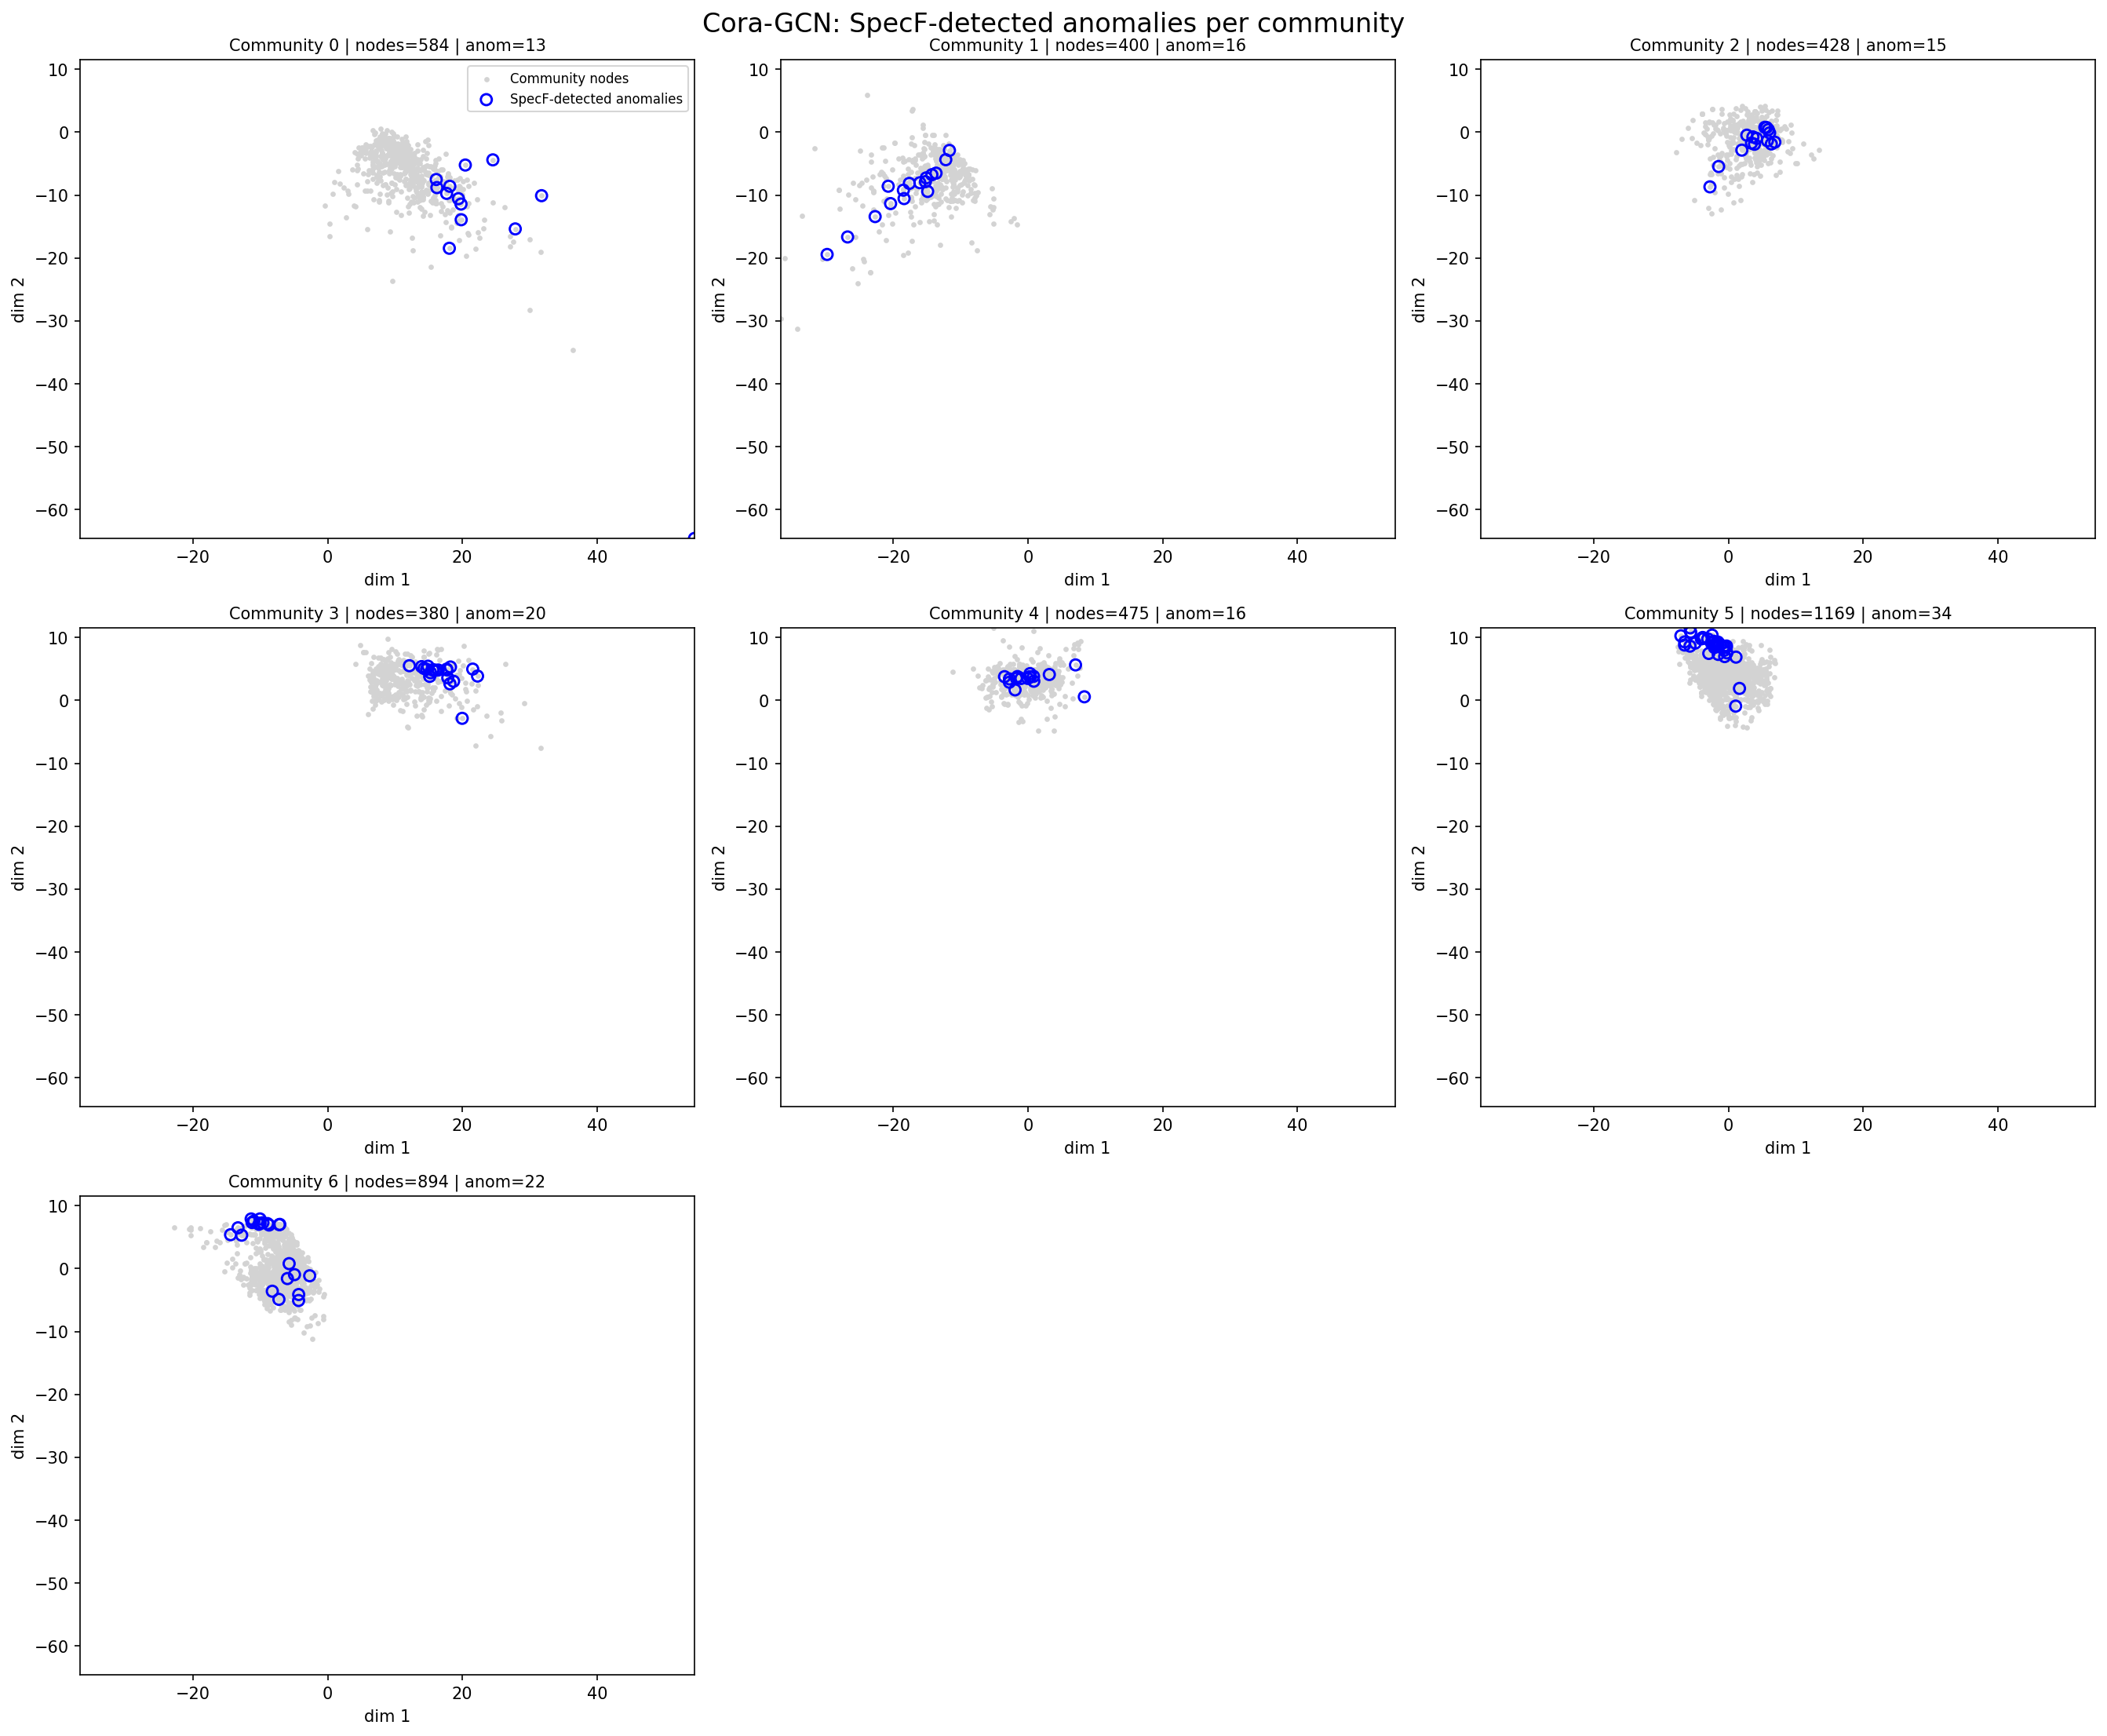

Saved plot to: /content/Results/SpecF_anomalies_per_community_onlyCommunityNodes.png


In [33]:
N = len(node_order)
specf_set = set(specf_anomalies)

# SpecF anomaly mask (global)
mask_anom = np.zeros(N, dtype=bool)
mask_anom[list(specf_set)] = True

# Community id per node (must align with X2 row i == node i)
comm_ids = np.array([clusters_dict[i] for i in range(N)])
all_comms = np.sort(np.unique(comm_ids))

# keep same axes for all community plots (fair comparison)
x_min, x_max = np.min(X2[:, 0]), np.max(X2[:, 0])
y_min, y_max = np.min(X2[:, 1]), np.max(X2[:, 1])


cols = 3
rows = math.ceil(len(all_comms) / cols)

# --------------------------------------------------
# Results folder
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "SpecF_anomalies_per_community_onlyCommunityNodes.png"

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5), dpi=150)
axes = np.array(axes).reshape(-1)

for ax_i, c in enumerate(all_comms):
    ax = axes[ax_i]

    # nodes in this community only
    mask_comm = (comm_ids == c)

    # anomalies inside this community
    mask_comm_anom = mask_comm & mask_anom

    # background: ONLY community nodes
    ax.scatter(
        X2[mask_comm, 0], X2[mask_comm, 1],
        s=5, color="lightgray", label="Community nodes"
    )

    # anomalies inside this community
    if mask_comm_anom.sum() > 0:
        ax.scatter(
            X2[mask_comm_anom, 0], X2[mask_comm_anom, 1],
            s=45, edgecolors="blue", facecolors="none",
            linewidths=1.4, label="SpecF-detected anomalies"
        )

    ax.set_title(
        f"Community {c} | nodes={mask_comm.sum()} | anom={mask_comm_anom.sum()}",
        fontsize=10
    )
    ax.set_xlabel("dim 1")
    ax.set_ylabel("dim 2")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # show legend only once
    if ax_i == 0:
        ax.legend(loc="upper right", fontsize=8)

# turn off unused subplots
for j in range(len(all_comms), len(axes)):
    axes[j].axis("off")

fig.suptitle("Cora-GCN: SpecF-detected anomalies per community", fontsize=16)
plt.tight_layout()

# --------------------------------------------------
# Save under Results
# --------------------------------------------------
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")

# dominant subject at all nodes VS dominant subject at anomalous nodes

In [34]:
# -------------------------------------------------
# Build anomaly mask
# -------------------------------------------------
specf_set = set(map(int, specf_anomalies))
df = df_results.copy()
df["is_anom"] = df["node_id"].astype(int).isin(specf_set)

# -------------------------------------------------
# Per-community dominant subjects
# -------------------------------------------------
rows = []

for c, g in df.groupby("community_id"):
    # dominant subject in the whole community
    subj_all = g["subject_name"].value_counts().idxmax()

    # dominant subject among anomalies (if exist)
    g_anom = g[g["is_anom"]]
    if len(g_anom) > 0:
        subj_anom = g_anom["subject_name"].value_counts().idxmax()
        anom_count = len(g_anom)
    else:
        subj_anom = "None"
        anom_count = 0

    rows.append({
        "community_id": c,
        "dominant_subject_all": subj_all,
        "dominant_subject_anom": subj_anom,
        "num_nodes": len(g),
        "num_anomalies": anom_count
    })

df_comm_summary = pd.DataFrame(rows).sort_values("community_id")
display(df_comm_summary)


community_id    dominant_subject_all   dominant_subject_anom  num_nodes  \
0             0      Genetic_Algorithms      Genetic_Algorithms        584   
1             1         Neural_Networks         Neural_Networks        400   
2             2              Case_Based  Reinforcement_Learning        428   
3             3  Reinforcement_Learning  Reinforcement_Learning        380   
4             4   Probabilistic_Methods   Probabilistic_Methods        475   
5             5                  Theory                  Theory       1169   
6             6         Neural_Networks           Rule_Learning        894   

   num_anomalies  
0             13  
1             16  
2             15  
3             20  
4             16  
5             34  
6             22

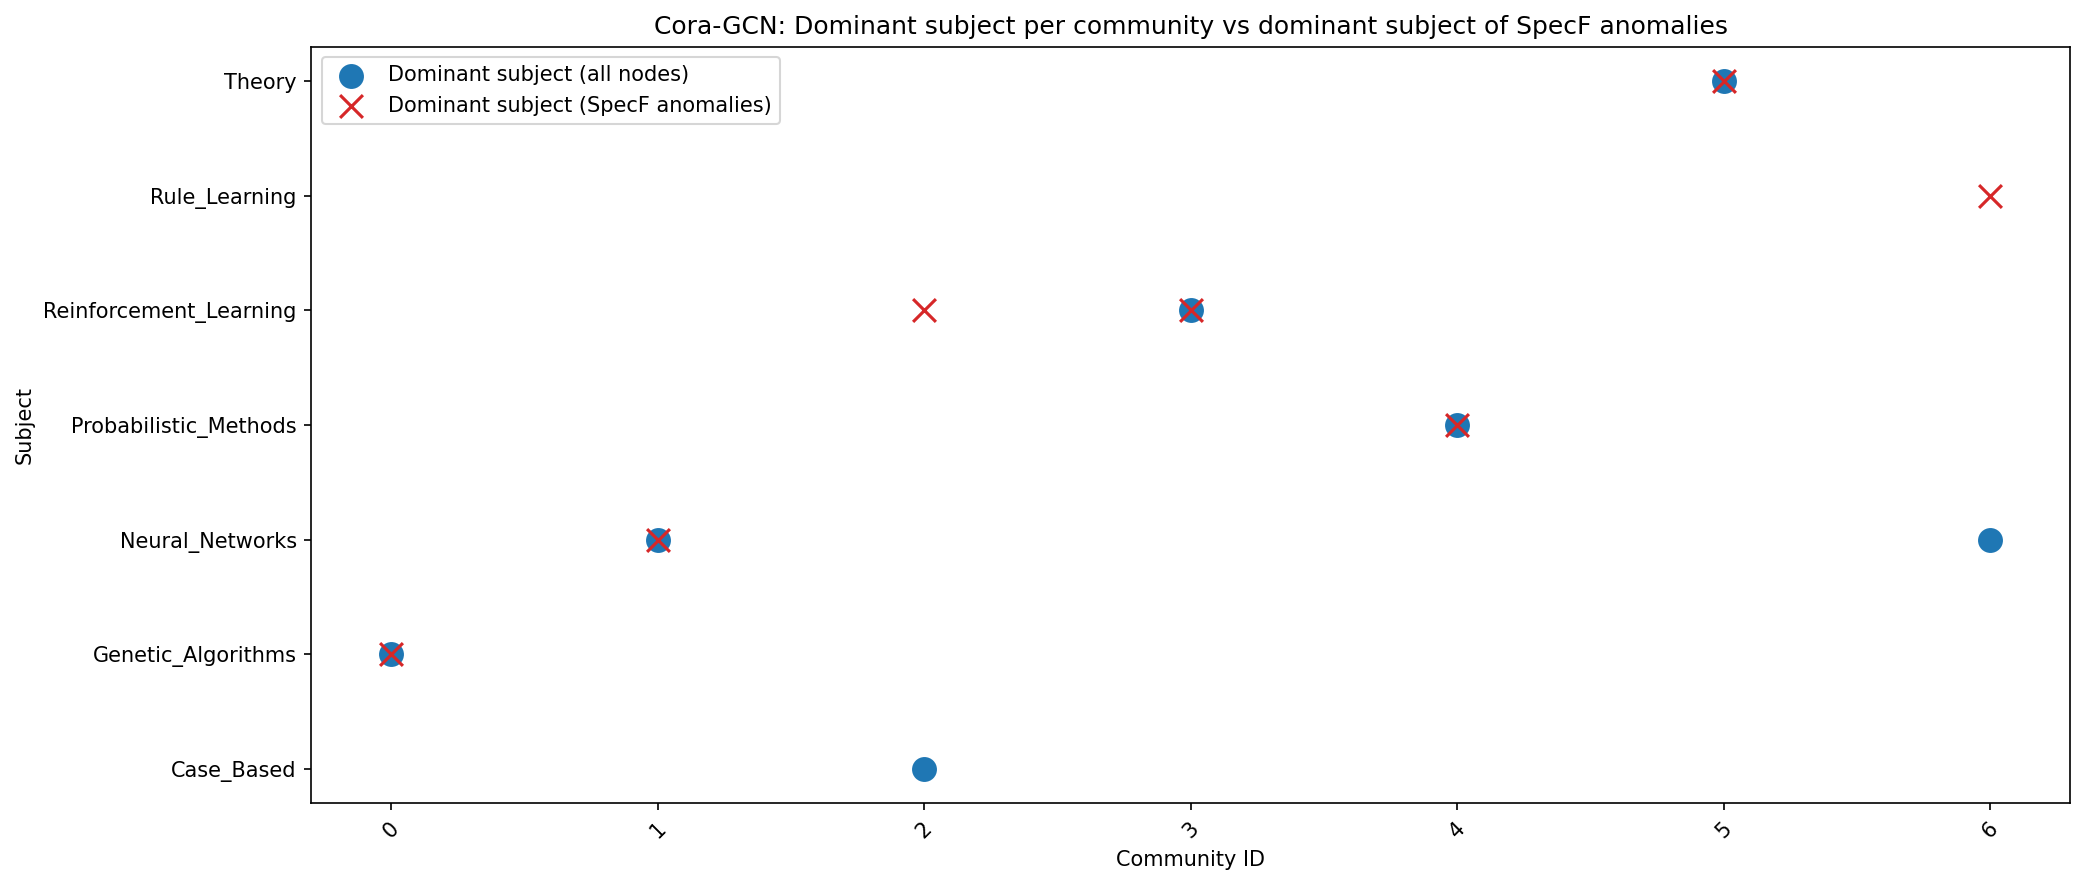

Saved plot to: /content/Results/Dominant_subjects_per_community_vs_anomalies.png


In [35]:
subjects = sorted(df["subject_name"].unique())
subject_to_id = {s: i for i, s in enumerate(subjects)}

df_comm_summary["subj_all_id"] = df_comm_summary["dominant_subject_all"].map(subject_to_id)
df_comm_summary["subj_anom_id"] = df_comm_summary["dominant_subject_anom"].map(
    lambda x: subject_to_id[x] if x in subject_to_id else -1
)

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "Dominant_subjects_per_community_vs_anomalies.png"


fig = plt.figure(figsize=(14, 6), dpi=150)

x = np.arange(len(df_comm_summary))

# dominant subject of all nodes
plt.scatter(
    x,
    df_comm_summary["subj_all_id"],
    s=120,
    label="Dominant subject (all nodes)",
    color="tab:blue"
)

# dominant subject of anomalies
plt.scatter(
    x,
    df_comm_summary["subj_anom_id"],
    s=120,
    label="Dominant subject (SpecF anomalies)",
    color="tab:red",
    marker="x"
)

plt.xticks(x, df_comm_summary["community_id"], rotation=45)
plt.yticks(
    np.arange(len(subjects)),
    subjects
)

plt.xlabel("Community ID")
plt.ylabel("Subject")
plt.title("Cora-GCN: Dominant subject per community vs dominant subject of SpecF anomalies")
plt.legend()
plt.tight_layout()

# Save under Results
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")

# min Y value and max Y value per community

In [36]:
# --------------------------------------------------
# Min / Max / Gap of SpecF_score for ALL nodes per community
# --------------------------------------------------
comm_minmax = (
    df.groupby("community_id")["SpecF_score"]
      .agg(
          min_Y="min",
          max_Y="max",
          num_nodes="count"
      )
      .reset_index()
      .sort_values("community_id")
)

# add gap
comm_minmax["Y_gap"] = comm_minmax["max_Y"] - comm_minmax["min_Y"]

display(comm_minmax)



community_id        min_Y         max_Y  num_nodes         Y_gap
0             0    20.732267  2.230951e+05        584  2.230743e+05
1             1   114.883846  1.613542e+05        400  1.612393e+05
2             2    72.190497  1.927420e+05        428  1.926698e+05
3             3  4002.079884  3.763465e+06        380  3.759463e+06
4             4    58.621693  1.727958e+05        475  1.727372e+05
5             5    33.321560  1.328728e+05       1169  1.328395e+05
6             6     2.078233  1.232923e+05        894  1.232903e+05

**Visualize the gap**

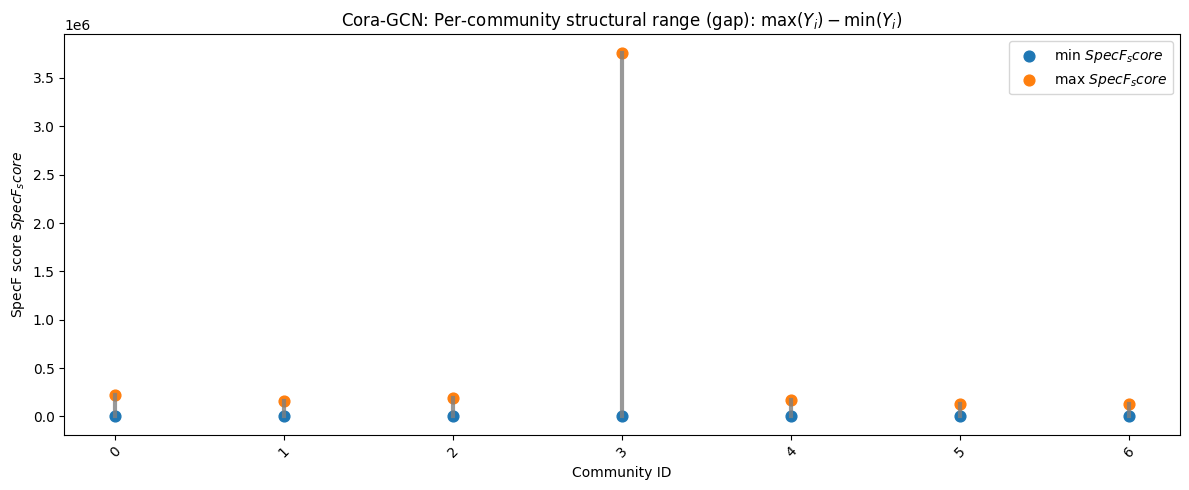

In [37]:
# -----------------------------
# 1) Validate required columns
# -----------------------------
if "community_id" not in df.columns:
    raise ValueError("df must contain a 'community_id' column.")

# allow either Y_i or SpecF_score
score_col = None
for c in ["Y_i", "SpecF_score", "SpecF_score_Y", "Y_score"]:
    if c in df.columns:
        score_col = c
        break

if score_col is None:
    raise ValueError("df must contain a score column like 'Y_i' or 'SpecF_score'.")

# -----------------------------
# 2) Aggregate per community
# -----------------------------
comm_minmax = (
    df.groupby("community_id")[score_col]
      .agg(min_Y="min", max_Y="max")
      .reset_index()
      .sort_values("community_id")
)

x = np.arange(len(comm_minmax))

# -----------------------------
# 3) Plot
# -----------------------------
plt.figure(figsize=(12, 5))

# vertical range line for each community (SAME COLOR)
for i, row in enumerate(comm_minmax.itertuples(index=False)):
    plt.plot(
        [i, i],
        [row.min_Y, row.max_Y],
        linewidth=3,
        color="gray",
        alpha=0.8
    )

# mark min and max points
plt.scatter(x, comm_minmax["min_Y"], s=60, label=rf"min ${score_col}$")
plt.scatter(x, comm_minmax["max_Y"], s=60, label=rf"max ${score_col}$")

plt.xticks(x, comm_minmax["community_id"].astype(int), rotation=45)
plt.xlabel("Community ID")
plt.ylabel(rf"SpecF score ${score_col}$")
plt.title(r"Cora-GCN: Per-community structural range (gap): $\max(Y_i)-\min(Y_i)$")
plt.legend()
plt.tight_layout()
plt.show()


# Top 20 words in normal nodes VS top 20 words in anomalous nodes

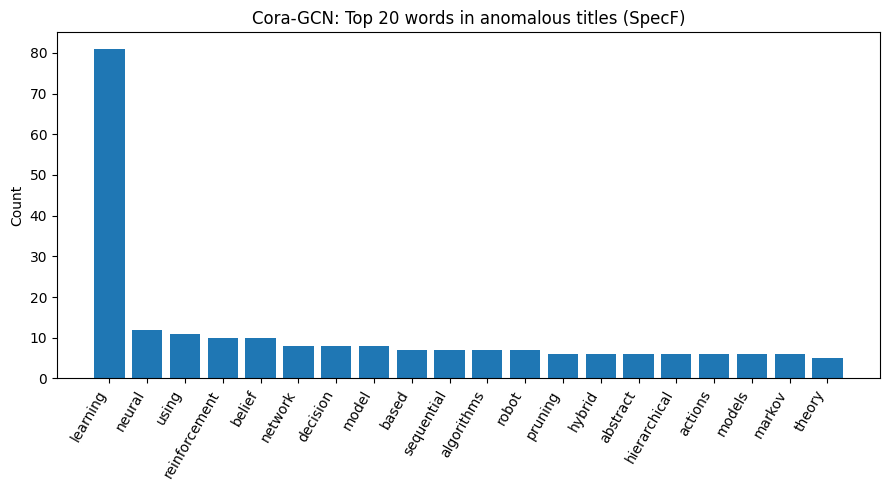

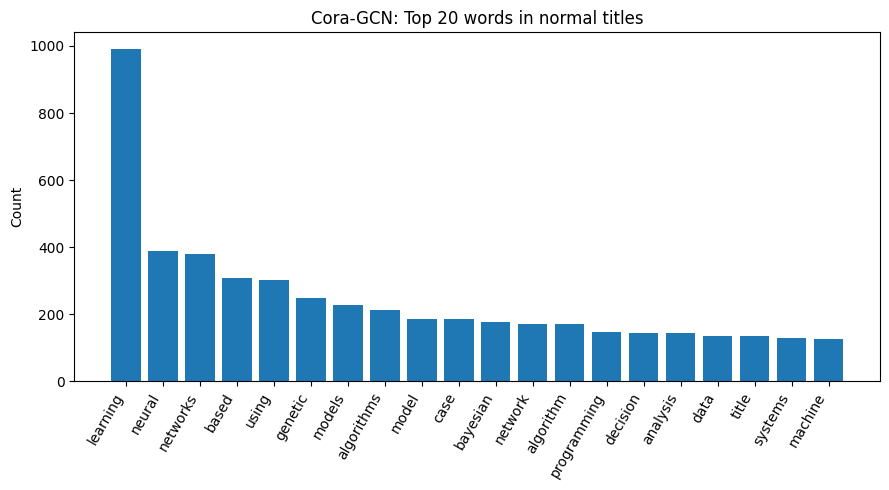

In [38]:
# ------------------------------------------------------------
# 0) Build anomaly mask from specf_anomalies (NO SpecF_anomaly column needed)
# ------------------------------------------------------------
# df_results MUST contain "node_id"
specf_set = set(map(int, specf_anomalies))

anom_mask = df_results["node_id"].astype(int).isin(specf_set).values  # boolean mask aligned to df_results rows


# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def _clean_and_tokenize(t):
    t = str(t).lower()
    toks = re.split(r"[^a-z0-9]+", t)
    toks = [w for w in toks if len(w) >= 3 and w not in ENGLISH_STOP_WORDS]
    return toks

def _top_words(series_titles, topk=20):
    all_tokens = []
    for tt in series_titles.astype(str).values:
        all_tokens.extend(_clean_and_tokenize(tt))
    cnt = Counter(all_tokens)
    return cnt.most_common(topk)


# ============================================================
# Plot 2: Word frequency contrast (top words) anomalies vs normal
# ============================================================
topk = 20
top_anom = _top_words(df_results.loc[anom_mask, "title"], topk=topk)
top_norm = _top_words(df_results.loc[~anom_mask, "title"], topk=topk)

# anomalies bar chart
if len(top_anom) > 0:
    words_a, vals_a = zip(*top_anom)
    x = np.arange(len(words_a))
    plt.figure(figsize=(9, 5))
    plt.bar(x, vals_a)
    plt.xticks(x, words_a, rotation=60, ha="right")
    plt.ylabel("Count")
    plt.title(f"Cora-GCN: Top {topk} words in anomalous titles (SpecF)")
    plt.tight_layout()
    plt.show()

# normal bar chart
if len(top_norm) > 0:
    words_n, vals_n = zip(*top_norm)
    x = np.arange(len(words_n))
    plt.figure(figsize=(9, 5))
    plt.bar(x, vals_n)
    plt.xticks(x, words_n, rotation=60, ha="right")
    plt.ylabel("Count")
    plt.title(f"Cora-GCN: Top {topk} words in normal titles")
    plt.tight_layout()
    plt.show()






# min Y value of an anomalous node and max Y value of a normal node per community

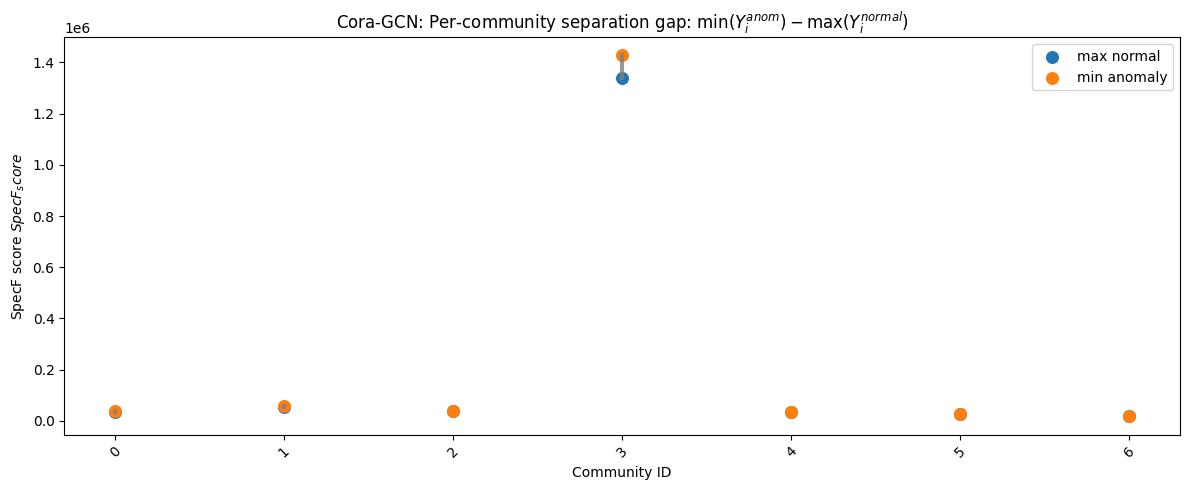

In [39]:
# -----------------------------
# 1) Validate required columns
# -----------------------------
required_cols = {"community_id", "is_anom"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"df is missing required columns: {missing}")

# allow either Y_i or SpecF_score
score_col = None
for c in ["Y_i", "SpecF_score", "SpecF_score_Y", "Y_score"]:
    if c in df.columns:
        score_col = c
        break

if score_col is None:
    raise ValueError("df must contain a score column like 'Y_i' or 'SpecF_score'.")

# -----------------------------
# 2) Aggregate per community
# -----------------------------
rows = []

for c, g in df.groupby("community_id"):
    g_norm = g[~g["is_anom"]]
    g_anom = g[g["is_anom"]]

    # skip communities without both types
    if len(g_norm) == 0 or len(g_anom) == 0:
        continue

    max_normal = g_norm[score_col].max()
    min_anom   = g_anom[score_col].min()

    rows.append({
        "community_id": int(c),
        "max_normal": max_normal,
        "min_anom": min_anom,
        "gap": min_anom - max_normal
    })

comm_gap = (
    pd.DataFrame(rows)
    .sort_values("community_id")
    .reset_index(drop=True)
)

x = np.arange(len(comm_gap))

# -----------------------------
# 3) Plot
# -----------------------------
plt.figure(figsize=(12, 5))

# vertical gap line (same color)
for i, row in comm_gap.iterrows():
    plt.plot(
        [i, i],
        [row.max_normal, row.min_anom],
        color="gray",
        linewidth=3,
        alpha=0.8
    )

# mark max normal & min anomaly
plt.scatter(x, comm_gap["max_normal"], s=70, label="max normal")
plt.scatter(x, comm_gap["min_anom"], s=70, label="min anomaly")

plt.xticks(x, comm_gap["community_id"], rotation=45)
plt.xlabel("Community ID")
plt.ylabel(rf"SpecF score ${score_col}$")
plt.title(r"Cora-GCN: Per-community separation gap: $\min(Y_i^{anom}) - \max(Y_i^{normal})$")
plt.legend()
plt.tight_layout()
plt.show()


In [40]:
# --------------------------------------------------
# Build base dataframe
# --------------------------------------------------
df = df_results.copy()

# anomaly mask
specf_set = set(map(int, specf_anomalies))
df["is_anom"] = df["node_id"].astype(int).isin(specf_set)

# attach Y_i score
if isinstance(Y_scores, dict):
    df["Y_i"] = df["node_id"].astype(int).map(lambda i: float(Y_scores[int(i)]))
else:
    df["Y_i"] = df["node_id"].astype(int).map(lambda i: float(Y_scores[int(i)]))

# --------------------------------------------------
# Compute per-community stats
# --------------------------------------------------
rows = []

for c, g in df.groupby("community_id"):
    # normal nodes
    g_norm = g[~g["is_anom"]]
    # anomalous nodes
    g_anom = g[g["is_anom"]]

    max_normal = g_norm["Y_i"].max() if len(g_norm) > 0 else np.nan
    min_anom   = g_anom["Y_i"].min() if len(g_anom) > 0 else np.nan

    rows.append({
        "community_id": c,
        "num_nodes": len(g),
        "num_normals": len(g_norm),
        "num_anomalies": len(g_anom),
        "max_Y_normal": max_normal,
        "min_Y_anomaly": min_anom,
        "gap(min_anom - max_normal)": (
            min_anom - max_normal
            if not np.isnan(max_normal) and not np.isnan(min_anom)
            else np.nan
        )
    })

df_gap = pd.DataFrame(rows).sort_values("community_id")
display(df_gap)


community_id  num_nodes  num_normals  num_anomalies  max_Y_normal  \
0             0        584          571             13  3.527223e+04   
1             1        400          384             16  5.390476e+04   
2             2        428          413             15  3.853839e+04   
3             3        380          360             20  1.339604e+06   
4             4        475          459             16  3.292660e+04   
5             5       1169         1135             34  2.581566e+04   
6             6        894          872             22  1.732830e+04   

   min_Y_anomaly  gap(min_anom - max_normal)  
0   3.820882e+04                 2936.587402  
1   5.946874e+04                 5563.985991  
2   4.047849e+04                 1940.100295  
3   1.427128e+06                87523.870301  
4   3.553208e+04                 2605.480909  
5   2.605472e+04                  239.059081  
6   1.835680e+04                 1028.502509

# Top 5 titles in normal nodes VS top 5 titles in anomalous node

In [41]:
# --------------------------------------------------
# Prepare dataframe
# --------------------------------------------------
df = df_results.copy()

specf_set = set(map(int, specf_anomalies))
df["is_anom"] = df["node_id"].astype(int).isin(specf_set)

# attach Y_i
df["Y_i"] = df["node_id"].astype(int).map(lambda i: float(Y_scores[int(i)]))

# --------------------------------------------------
# Helper: numbered titles in one cell
# --------------------------------------------------
def numbered_multiline(titles):
    return "\n".join(f"{i+1}. {t}" for i, t in enumerate(titles))

# --------------------------------------------------
# Collect top-5 titles per community
# --------------------------------------------------
rows = []

for c, g in df.groupby("community_id"):
    top_norm = (
        g[~g["is_anom"]]
        .sort_values("Y_i", ascending=False)
        .head(5)
    )

    top_anom = (
        g[g["is_anom"]]
        .sort_values("Y_i", ascending=False)
        .head(5)
    )

    rows.append({
        "community_id": c,
        "top5_normal_titles": numbered_multiline(top_norm["title"].tolist()),
        "top5_anomalous_titles": numbered_multiline(top_anom["title"].tolist())
    })

df_top_titles = (
    pd.DataFrame(rows)
    .sort_values("community_id")
    .reset_index(drop=True)
)

# --------------------------------------------------
# Display in notebook
# --------------------------------------------------
from IPython.display import HTML, display

def newline_to_br(text):
    if not isinstance(text, str):
        return text
    return text.replace("\n", "<br>")

df_display = df_top_titles.copy()
df_display["top5_normal_titles"] = df_display["top5_normal_titles"].apply(newline_to_br)
df_display["top5_anomalous_titles"] = df_display["top5_anomalous_titles"].apply(newline_to_br)

display(HTML(df_display.to_html(escape=False)))

# --------------------------------------------------
# Export to Excel (Results folder)
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

output_file = RESULTS_DIR / "Cora_top5_titles_per_community_GCN.xlsx"
df_top_titles.to_excel(output_file, index=False)

# Enable wrap-text formatting
wb = load_workbook(output_file)
ws = wb.active

wrap = Alignment(wrap_text=True, vertical="top")

headers = [cell.value for cell in ws[1]]
col_norm = headers.index("top5_normal_titles") + 1
col_anom = headers.index("top5_anomalous_titles") + 1

for row in range(2, ws.max_row + 1):
    ws.cell(row=row, column=col_norm).alignment = wrap
    ws.cell(row=row, column=col_anom).alignment = wrap

wb.save(output_file)

print(f"✅ Excel file saved (with wrap-text enabled): {output_file.resolve()}")

✅ Excel file saved (with wrap-text enabled): /content/Results/Cora_top5_titles_per_community_GCN.xlsx
